In [1]:
%load_ext autoreload
%autoreload 2

import os,sys,warnings
import h5py, pandas
import numpy as np
np.seterr(invalid=['ignore','warn'][0])
np.set_printoptions(legacy='1.25')
import math,cmath,pickle
from matplotlib.backends.backend_pdf import PdfPages
from scipy.optimize import curve_fit,fsolve
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('default')
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.titlesize'] = 20
mpl.rcParams['figure.figsize'] = [6.4*1.2,4.8*1.2]
mpl.rcParams['axes.labelsize'] = 24
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['lines.marker'] = 's'
mpl.rcParams['lines.linestyle'] = ''
mpl.rcParams['lines.markersize'] = 4
mpl.rcParams['errorbar.capsize'] = 6
mpl.rcParams['xtick.labelsize'] = mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['xtick.major.size'] = mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['xtick.top']=mpl.rcParams['ytick.right']=True
mpl.rcParams['xtick.direction']=mpl.rcParams['ytick.direction']='in'
mpl.rcParams['legend.fontsize'] = 24
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

# mpl.rcParams.update({"axes.grid" : True})
import util as yu
yu.flag_fast=False

enss=['b','c','d','e']
ens2full={'a24':'cA211.53.24','a':'cA2.09.48','b':'cB211.072.64','c':'cC211.060.80','d':'cD211.054.96','e':'cE211.044.112'}
ens2label={'a24':'A24','a':'A48','b':'B64','c':'C80','d':'D96','e':'E112'}
ens2a={'a24':0.0908,'a':0.0938,'b':0.07957,'c':0.06821,'d':0.05692,'e':0.04892} # fm
ens2N={'a24':24,'a':48,'b':64,'c':80,'d':96,'e':112}
ens2N_T={'a24':24*2,'a':48*2,'b':64*2,'c':80*2,'d':96*2,'e':112*2}

ens2Z_1d_V={'b':1.1262,'c':1.1573,'d':1.1930,'e':1.2175}

# ens2mN={'a':931}
# ens2mpiC={'a':131}
# ens2mpi0={'a':111}

ens2amu={'a24':0.0053,'a':0.0009,'b':0.00072}
ens2amus={'b':0.0186}
ens2amuc={'b':0.249}
ens2ZP={'a24':(0.4670,0.0046),'a':(0.500,0.030)}

hbarc = 1/197.3
ens2aInv={ens:1/(ens2a[ens]*hbarc) for ens in enss} # MeV

ens2tfs={'b':range(2,26+1),'c':range(2,28+1),'d':range(2,32+1),'e':range(2,32+1)}

def fsolve2(func,x0):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        res=fsolve(func, x0)[0]
    return res if res!=x0 else np.NaN

# ens='b'
# ens2a[ens]*hbarc*1000

def find_t_cloest(ens,t):
    return round(t/ens2a[ens])

In [5]:
t=np.array([743*(200+85+64),400*(650),(256+112)*494,516*100])
t/t[0]

array([1.        , 1.00267251, 0.70106862, 0.19899193])

In [2]:
data={}

flas=['j+','js','jc'][1:2]
for ens in enss:
    print(ens)
    data[ens]={}
    tfs=ens2tfs[ens]

    path=f'/p/project/ngff/li47/code/projectData/02_discNJN_1D/{ens2full[ens]}/data_earlytest/test.h5'
    with h5py.File(path) as f:
        data[ens]['N0']=yu.jackknife(f['N_mom0'])
        data[ens]['N1']=yu.jackknife(f['N_mom1'])
        
        data[ens]['P44']={}
        data[ens]['P4i']={}
        for fla in flas:
            data[ens]['P44'][fla]={}
            data[ens]['P4i'][fla]={}
            for tf in tfs:
                data[ens]['P44'][fla][tf]=yu.jackknife(f[f'{fla}/P44(G0,0,0)/{tf}'])
                data[ens]['P4i'][fla][tf]=yu.jackknife(f[f'{fla}/P4i(G0,pi,pi)/{tf}'][:])

b
c
d
e


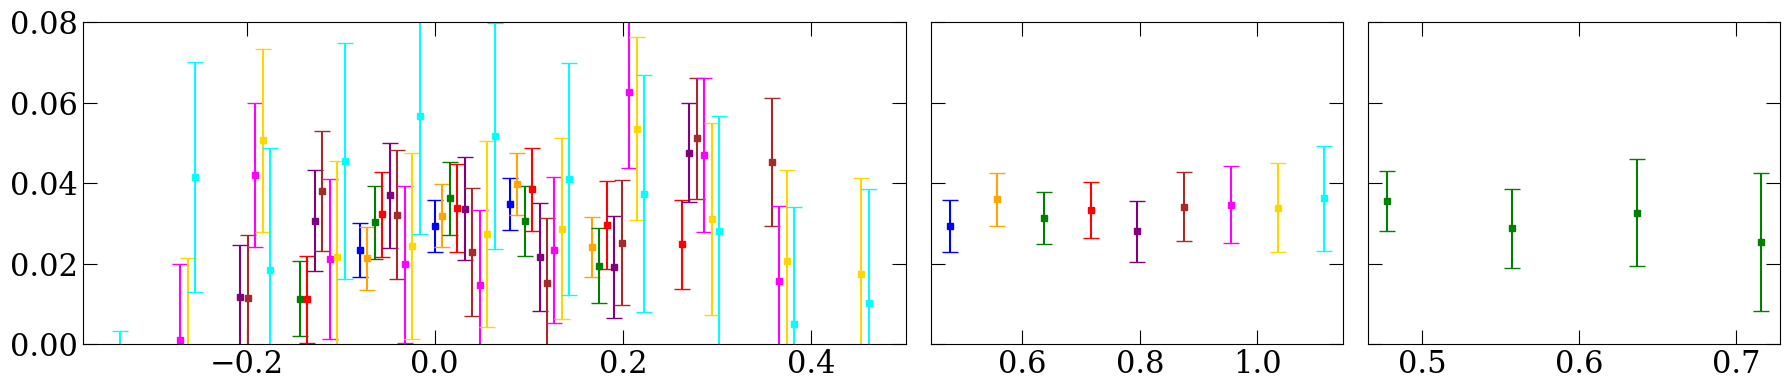

In [8]:
enss_plt=['b']

fix, axs = yu.getFigAxs(len(enss_plt),3,Lrow=4,Lcol=6,sharex='col',sharey=True, gridspec_kw={'width_ratios': [2, 1, 1]})
axs[0,0].set_ylim([0,0.08])

j='js'
for i_ens,ens in enumerate(enss_plt):
    xunit=ens2a[ens]; yunit=1
    tfs=ens2tfs[ens]
    tfs_plt=range(6,14+1,1)
    tfs_fit=tfs_plt
    cN1=np.real(data[ens]['N1'])
    c3ptDic={tf:np.real(data[ens]['P4i'][j][tf]/(1j*2*np.pi/ens2N[ens])) for tf in tfs}
    ratioDic={tf:c3ptDic[tf]/cN1[:,tf:tf+1] for tf in tfs}

    ax=axs[i_ens,0]
    colors=['b','orange','g','r','purple','brown','magenta','gold','cyan']
    t_cut=2
    for i_tf,tf in enumerate(tfs_plt):
        ratio=ratioDic[tf]
        mean,err=yu.jackme(ratio)
        tcs=np.arange(t_cut,tf-t_cut+1)
        plt_x=(tcs-tf/2+0.1*(tf-6)+ (0.5 if tf%2!=0 else 0))*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
        # plt_x=(tcs-tf/2)*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
        ax.errorbar(plt_x,plt_y,plt_yerr,color=colors[i_tf])  
         
    ax=axs[i_ens,1]
    tcmin=3
    for i_tf,tf in enumerate(tfs_fit):
        ratio=ratioDic[tf]
        y_jk=ratio[:,tcmin:tf-tcmin+1]
        def fitfunc(pars):
            return list(pars)*(tf-2*tcmin+1)
        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04])
        
        mean,err=yu.jackme(pars_jk)
        plt_x=tf*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
        ax.errorbar(plt_x,plt_y,plt_yerr,color=colors[i_tf])  
        
    ax=axs[i_ens,2]
    tfmins=[6,7,8,9]
    ratioSummedDic={tf:np.sum(ratioDic[tf][:,tcmin:tf-tcmin+1],axis=1) for tf in tfs}
    for tfmin in tfmins:
        y_jk=np.transpose([ratioSummedDic[tf] for tf in tfs_fit if tf>=tfmin])
        num=y_jk.shape[1]
        def fitfunc(pars):
            g,c=pars
            return g*np.arange(num)+c
        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04,1])
        
        mean,err=yu.jackme(pars_jk[:,0])
        plt_x=tfmin*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
        ax.errorbar(plt_x,plt_y,plt_yerr,color='g')  
    
plt.tight_layout()

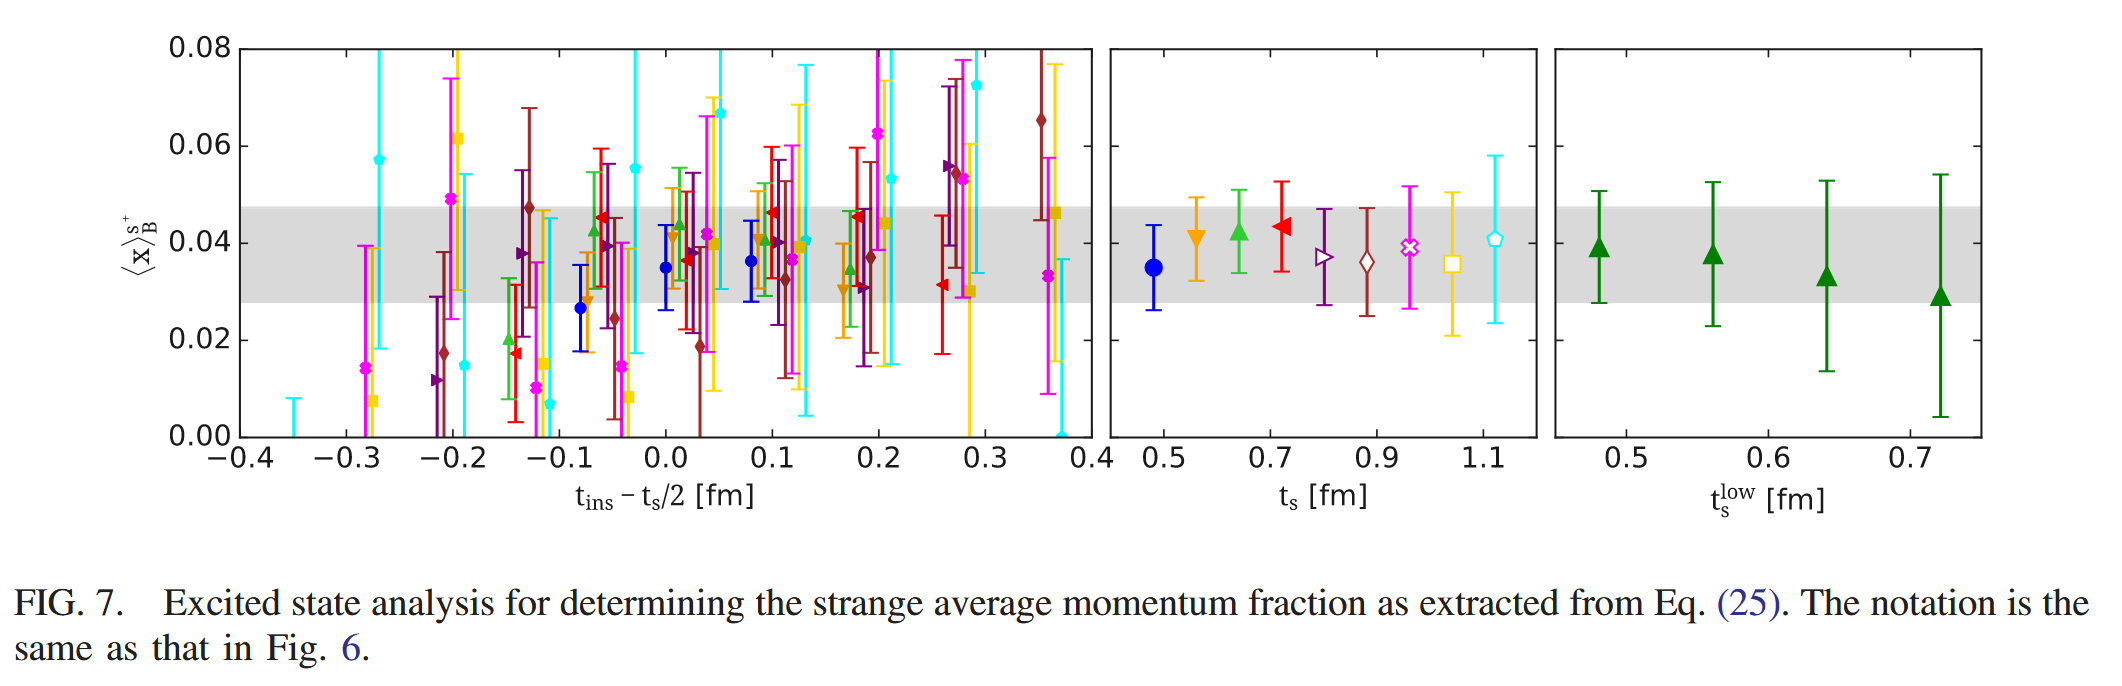

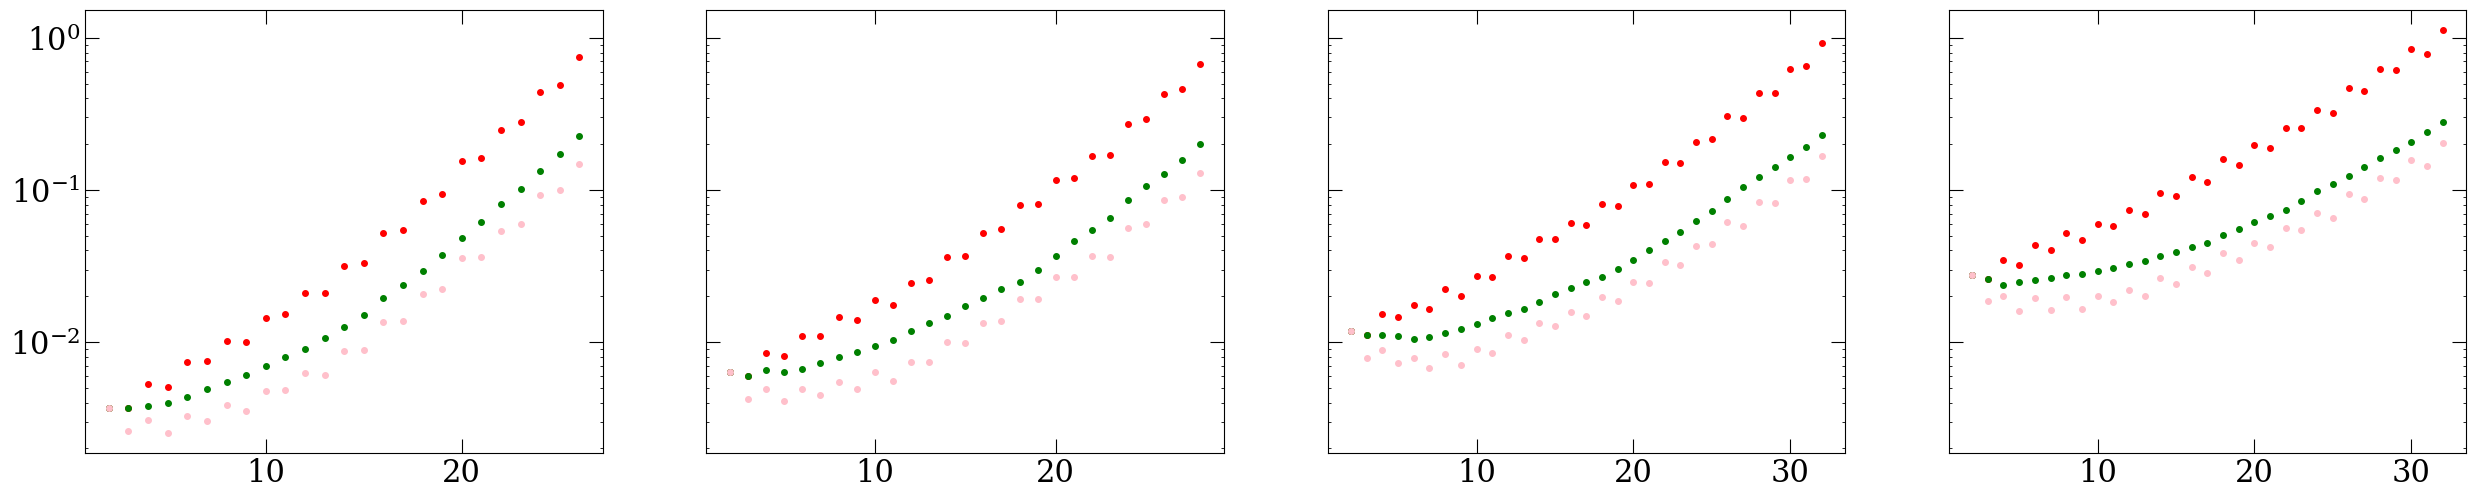

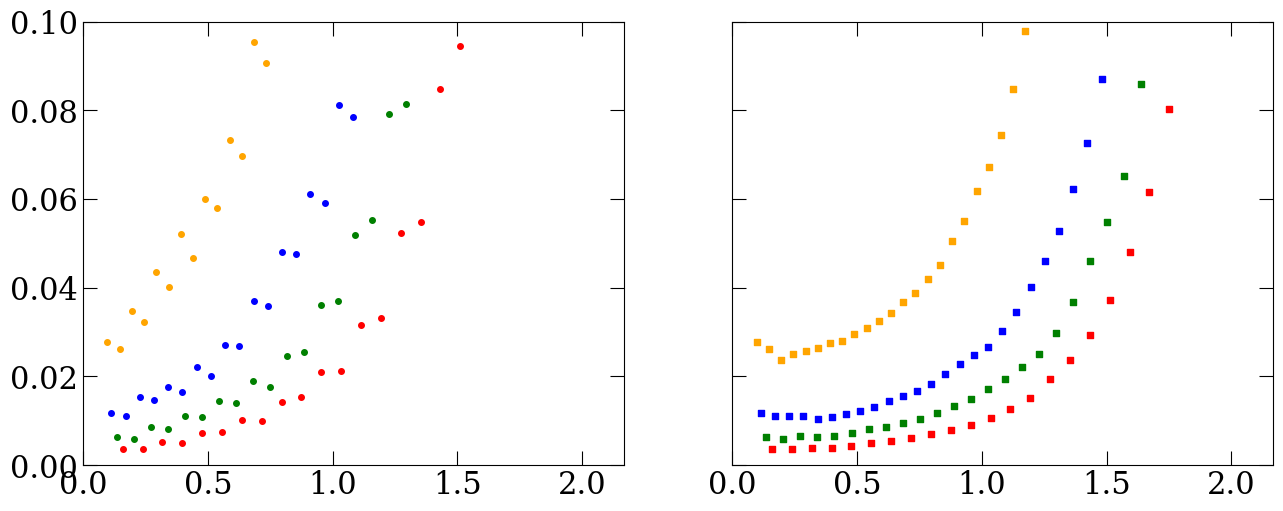

In [3]:
fix, axs = yu.getFigAxs(1,len(enss),sharey=True)
threshold=0.05

ens2Z=ens2Z_1d_V

j='js'
for i_ens,ens in enumerate(enss):
    tfs=ens2tfs[ens]
    cN1=np.real(data[ens]['N1'])
    c3ptDic={tf:np.real(data[ens]['P4i'][j][tf]/(1j*2*np.pi/ens2N[ens])) for tf in tfs}
    ratioDic={tf:c3ptDic[tf]/cN1[:,tf:tf+1] for tf in tfs}
    
    ax=axs[0,i_ens]
    for i_tf,tf in enumerate(tfs):
        mean,err=yu.jackme(ratioDic[tf][:,tf//2]) if tf%2==0 else yu.jackme((ratioDic[tf][:,tf//2]+ratioDic[tf][:,tf//2+1])/2)
        plt_y=err*ens2Z[ens]
        ax.scatter(tf,plt_y, color='r')
        
        tcmin=1
        if tf-tcmin+1>tcmin:
            t=ratioDic[tf][:,tcmin:(tf-tcmin+1)]
            Ndata=t.shape[1]
            mean,err=yu.jackme(np.mean(t,axis=1))
            # print(tf,Ndata,(plt_y/err)**2)
            plt_y=err*ens2Z[ens]
            ax.scatter(tf,plt_y, color='g')
            
            mean,err=yu.jackme(ratioDic[tf][:,tf//2]) if tf%2==0 else yu.jackme((ratioDic[tf][:,tf//2]+ratioDic[tf][:,tf//2+1])/2)
            plt_y=err*ens2Z[ens]/np.sqrt(Ndata)
            ax.scatter(tf,plt_y, color='pink')
            
    ax.set_yscale('log')


fix, axs = yu.getFigAxs(1,2,sharey=True)
threshold=0.05
colors=['r','g','b','orange']
for i_ens,ens in enumerate(enss):
    xunit=ens2a[ens]
    tfs=ens2tfs[ens]
    cN1=np.real(data[ens]['N1'])
    c3ptDic={tf:np.real(data[ens]['P4i'][j][tf]/(1j*2*np.pi/ens2N[ens])) for tf in tfs}
    ratioDic={tf:c3ptDic[tf]/cN1[:,tf:tf+1] for tf in tfs}
    
    ax=axs[0,0]; color=colors[i_ens]
    for i_tf,tf in enumerate(tfs):
        mean,err=yu.jackme(ratioDic[tf][:,tf//2]) if tf%2==0 else yu.jackme((ratioDic[tf][:,tf//2]+ratioDic[tf][:,tf//2+1])/2)
        plt_y=err*ens2Z[ens]
        ax.scatter(tf*xunit,plt_y, color=color, marker='o')
    
    ax=axs[0,1]; color=colors[i_ens]
    for i_tf,tf in enumerate(tfs):
        tcmin=1
        if tf-tcmin+1>tcmin:
            t=ratioDic[tf][:,tcmin:(tf-tcmin+1)]
            Ndata=t.shape[1]
            mean,err=yu.jackme(np.mean(t,axis=1))
            plt_y=err*ens2Z[ens]
            ax.scatter(tf*xunit,plt_y, color=color, marker='s')
            
            # mean,err=yu.jackme(ratioDic[tf][:,tf//2]) if tf%2==0 else yu.jackme((ratioDic[tf][:,tf//2]+ratioDic[tf][:,tf//2+1])/2)
            # plt_y=err*ens2Z[ens]/np.sqrt(Ndata)
            # ax.scatter(tf,plt_y, color=color, marker='d')
            
    # ax.set_yscale('log')
    ax.set_ylim([0,0.1])

(743, 37) [1, 11, 21, 31]


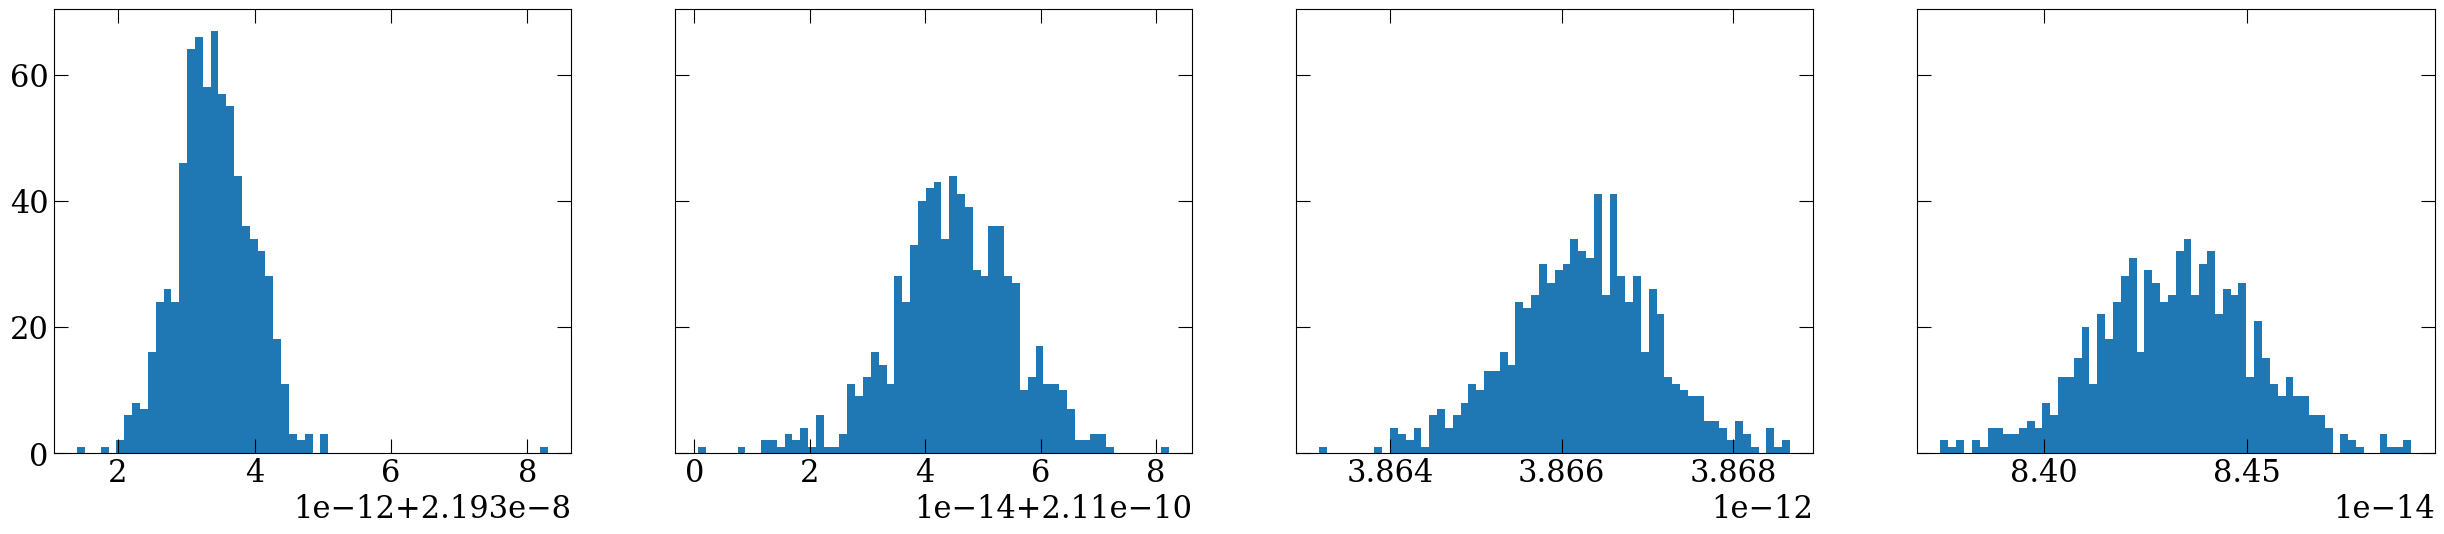

In [6]:
tfs_plt=range(1,37,10)
fix, axs = yu.getFigAxs(1,len(tfs_plt),sharey=True)
ens='b'
cN1=np.real(data[ens]['N1'])
print(cN1.shape, list(tfs_plt))
tfs=ens2tfs[ens]
c3ptDic={tf:np.real(data[ens]['P4i'][j][tf]/(1j*2*np.pi/ens2N[ens])) for tf in tfs}
ratioDic={tf:c3ptDic[tf]/cN1[:,tf:tf+1] for tf in tfs}

for i_tf,tf in enumerate(tfs_plt):
    # ratio=ratioDic[tf][:,tf//2]
    ratio=cN1[:,tf]
    # mean,err=yu.jackme(ratio)
    
    ax=axs[0,i_tf]
    # ax.errorbar(mean,20,xerr=err/np.sqrt(len(ratio)))
    ax.hist(ratio,bins=60)

In [ ]:
# compare two

# enss_plt=['b','c','d','e']

# xlim0=[-0.5,0.5]
# xlim1=[0,1.6]
# xlim2=[0,1.6]
# xlim3=[0,1.6]

# ylim=[0,0.08]
# ylim=[-0.02,0.1]

# fix, axs = yu.getFigAxs(len(enss_plt),3,Lrow=4,Lcol=6,sharex='col',sharey=True, gridspec_kw={'width_ratios': [3, 2, 2]})
# axs[0,0].set_xlim(xlim0)
# axs[0,1].set_xlim(xlim1)
# axs[0,2].set_xlim(xlim2)
# axs[0,0].set_ylim(ylim)

# symmetrizeQ=False

# ens2Z=ens2Z_1d_V
# j='js'

# res={}; res2={}
# for i_ens,ens in enumerate(enss_plt):
#     xunit=ens2a[ens]; yunit=ens2Z[ens]
#     tfs=ens2tfs[ens]

#     tfs_fit=[tf for tf in tfs]
#     cN1=np.real(data[ens]['N1'])
#     c3ptDic={tf:np.real(data[ens]['P4i'][j][tf]/(1j*2*np.pi/ens2N[ens])) for tf in tfs}
#     if symmetrizeQ:
#         c3ptDic={tf:(c3ptDic[tf]+c3ptDic[tf][:,::-1])/2 for tf in tfs}
#     ratioDic={tf:c3ptDic[tf]/cN1[:,tf:tf+1] for tf in tfs}

#     # for tf in tfs:
#     #     error=0.3
#     #     shape=ratioDic[tf].shape
#     #     t=yu.jackknife(np.random.randn(*shape)*error)
#     #     ratioDic[tf]+=t
    
#     tfmax_cut=find_t_cloest(ens,1.2)
#     if ens=='d':
#         tfmax_cut=find_t_cloest(ens,0.9)
#     if ens=='e':
#         tfmax_cut=find_t_cloest(ens,0.6)

#     ax=axs[i_ens,0]
#     colors=['b','orange','g','r','purple','brown','magenta','gold','cyan']
#     colors_tcmin=['r','g','b','orange','purple']
#     t_cut=1
#     for i_tf,tf in enumerate(tfs_fit):
#         if tf%2!=0 or tf>tfmax_cut:
#             continue
#         ratio=ratioDic[tf]
#         mean,err=yu.jackme(ratio)
#         tcs=np.arange(t_cut,tf-t_cut+1)
#         plt_x=(tcs-tf/2+0.02*(tf-6))*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
#         # plt_x=(tcs-tf/2)*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
#         ax.errorbar(plt_x,plt_y,plt_yerr,color=colors[i_tf] if i_tf<len(colors) else None)
        
#     # tfmax_cut=find_t_cloest(ens,1.2)

#     # tc_cut=find_t_cloest(ens,0.05)
#     # tfmax_cut=find_t_cloest(ens,1.5)
#     print(ens,tfmax_cut)
    
#     tcmins=[1,2,3,4]
#     # tcmins=[1,2,3]
#     ax=axs[i_ens,1]
#     fits=[]
#     for i_tcmin, tcmin in enumerate(tcmins):
#         tfmins=[tf for tf in tfs_fit[:-3] if tf>=2*tcmin and tf<=tfmax_cut]
#         for tfmin in tfmins:
#             if tfmin<tcmin*2:
#                 continue
#             y_jk=np.concatenate([ratioDic[tf][:,tcmin:tf-tcmin+1] for tf in tfs_fit if tf>=tfmin and tf<=tfmax_cut],axis=1)
#             if symmetrizeQ:
#                 y_jk=np.concatenate([ratioDic[tf][:,tcmin:tf//2+1] for tf in tfs_fit if tf>=tfmin and tf<=tfmax_cut],axis=1)

#             Ndata=y_jk.shape[1]
#             def fitfunc(pars):
#                 return list(pars)*Ndata
#             # pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04],mask='uncorrelated')
#             pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04])
#             fits.append([(tcmin,tfmin),pars_jk,chi2_jk,Ndof])
    
#     tfmins=list(set([fit[0][1] for fit in fits])); tfmins.sort()
#     for tfmin in tfmins:
#         t=[fit for fit in fits if fit[0][1]==tfmin]
#         pars_jk,props_jk=yu.jackMA(t)
#         ind_mpf=np.argmax(np.mean(props_jk,axis=0))
#         fitlabel,pars_jk,chi2_jk,Ndof=t[ind_mpf]
#         i_tcmin=tcmins.index(fitlabel[0])
        
#         mean,err=yu.jackme(pars_jk[:,0])
#         plt_x=(tfmin+i_tcmin*0.1)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
#         i_tf=tfs_fit.index(tfmin)
#         ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin]) 
        
#         chi2R=np.mean(chi2_jk)/Ndof
#         ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/24
#         ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_yerr-chi2_shift),color=colors_tcmin[i_tcmin],size=8,ha='center')       
        
#     pars_jk,props_jk=yu.jackMA(fits)
#     # ind_mpf=np.argmax(np.mean(props_jk,axis=0))
#     pars_mean,pars_err=yu.jackme(pars_jk)
#     res[ens]=[pars_mean[0],pars_err[0]]
#     for icol in range(2):
#         ax.set_xlim(ax.get_xlim())
#         ax=axs[i_ens,icol]
        
#         plt_x=ax.get_xlim(); plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
#         ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='grey',alpha=0.2)    
        
#         if icol==0:
#             print(ens,yu.un2str(plt_y,plt_err))
            
#     tfmax_cut=find_t_cloest(ens,1.2)
#     if ens=='d':
#         tfmax_cut=find_t_cloest(ens,0.9)
#     if ens=='e':
#         tfmax_cut=find_t_cloest(ens,0.6)
#     print(ens,tfmax_cut,'second')
#     ax=axs[i_ens,2]
#     fits=[]
#     for i_tcmin, tcmin in enumerate(tcmins):
#         tfmins=[tf for tf in tfs_fit[:-3] if tf>=2*tcmin and tf<=tfmax_cut]
#         for tfmin in tfmins:
#             if tfmin<tcmin*2:
#                 continue
#             y_jk=np.concatenate([ratioDic[tf][:,tcmin:tf-tcmin+1] for tf in tfs_fit if tf>=tfmin and tf<=tfmax_cut],axis=1)
#             if symmetrizeQ:
#                 y_jk=np.concatenate([ratioDic[tf][:,tcmin:tf//2+1] for tf in tfs_fit if tf>=tfmin and tf<=tfmax_cut],axis=1)

#             Ndata=y_jk.shape[1]
#             def fitfunc(pars):
#                 return list(pars)*Ndata
#             # pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04],mask='uncorrelated')
#             pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04])
#             fits.append([(tcmin,tfmin),pars_jk,chi2_jk,Ndof])
    
#     tfmins=list(set([fit[0][1] for fit in fits])); tfmins.sort()
#     for tfmin in tfmins:
#         t=[fit for fit in fits if fit[0][1]==tfmin]
#         pars_jk,props_jk=yu.jackMA(t)
#         ind_mpf=np.argmax(np.mean(props_jk,axis=0))
#         fitlabel,pars_jk,chi2_jk,Ndof=t[ind_mpf]
#         i_tcmin=tcmins.index(fitlabel[0])
        
#         mean,err=yu.jackme(pars_jk[:,0])
#         plt_x=(tfmin+i_tcmin*0.1)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
#         i_tf=tfs_fit.index(tfmin)
#         ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin]) 
        
#         chi2R=np.mean(chi2_jk)/Ndof
#         ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/24
#         ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_yerr-chi2_shift),color=colors_tcmin[i_tcmin],size=8,ha='center')       
        
#     pars_jk,props_jk=yu.jackMA(fits)
#     # ind_mpf=np.argmax(np.mean(props_jk,axis=0))
#     pars_mean,pars_err=yu.jackme(pars_jk)
#     res2[ens]=[pars_mean[0],pars_err[0]]
#     for icol in [2]:
#         ax.set_xlim(ax.get_xlim())
#         ax=axs[i_ens,icol]
        
#         plt_x=ax.get_xlim(); plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
#         ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='pink',alpha=0.2)    
        
#         if icol==0:
#             print(ens,yu.un2str(plt_y,plt_err))

# plt.tight_layout()

# fix, axs = yu.getFigAxs(1,2,Lrow=4,Lcol=6,sharex=True,sharey=True)
# ax=axs[0,0]
# ax.set_ylim(ylim)

# a2s=np.array([ens2a[ens]**2 for ens in enss])
# gs_m=np.array([res[ens][0]*ens2Z[ens] for ens in enss])
# gs_e=np.array([res[ens][1]*ens2Z[ens] for ens in enss])

# ax.errorbar(a2s,gs_m,gs_e,color='r') 

# mean=gs_m; err=gs_e
# def fitfunc(a2,g):
#     return g+0*a2
# popt,pcov=curve_fit(fitfunc,a2s,mean,sigma=err,absolute_sigma=True)
# r=fitfunc(a2s,*popt)-mean
# color='g'
# chi2R=r.T @ np.linalg.inv(np.diag(err**2)) @ r / (len(enss)-1)
# a2s2=np.arange(0,0.008,0.001)

# mean,err,cov=yu.propagateError(lambda pars:fitfunc(a2s2,*pars), popt, pcov)
# ax.plot(a2s2,mean,'--',color=color)
# ax.fill_between(a2s2,mean-err,mean+err,color=color,alpha=0.2)
# ax.errorbar([0],[popt[0]],np.sqrt(pcov[0,0]),color=color)
# ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
# ax.annotate("%0.1f" %chi2R,(0,popt[0]-np.sqrt(pcov[0,0])-chi2_shift),color=color)

# print('c.l._const',yu.un2str(popt[0],np.sqrt(pcov[0,0])))

# mean=gs_m; err=gs_e
# def fitfunc(a2,g,c):
#     return g+c*a2
# popt,pcov=curve_fit(fitfunc,a2s,mean,sigma=err,absolute_sigma=True)
# r=fitfunc(a2s,*popt)-mean
# color='b'
# chi2R=r.T @ np.linalg.inv(np.diag(err**2)) @ r / (len(enss)-2)
# a2s2=np.arange(0,0.008,0.001)

# mean,err,cov=yu.propagateError(lambda pars:fitfunc(a2s2,*pars), popt, pcov)
# ax.plot(a2s2,mean,'--',color=color)
# ax.fill_between(a2s2,mean-err,mean+err,color=color,alpha=0.2)
# ax.errorbar([0],[popt[0]],np.sqrt(pcov[0,0]),color=color)
# ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
# ax.annotate("%0.1f" %chi2R,(0,popt[0]-np.sqrt(pcov[0,0])-chi2_shift),color=color)

# print('c.l._linear',yu.un2str(popt[0],np.sqrt(pcov[0,0])))


# ax=axs[0,1]
# ax.set_ylim(ylim)

# a2s=np.array([ens2a[ens]**2 for ens in enss])
# gs_m=np.array([res2[ens][0]*ens2Z[ens] for ens in enss])
# gs_e=np.array([res2[ens][1]*ens2Z[ens] for ens in enss])

# ax.errorbar(a2s,gs_m,gs_e,color='r') 

# mean=gs_m; err=gs_e
# def fitfunc(a2,g):
#     return g+0*a2
# popt,pcov=curve_fit(fitfunc,a2s,mean,sigma=err,absolute_sigma=True)
# r=fitfunc(a2s,*popt)-mean
# color='g'
# chi2R=r.T @ np.linalg.inv(np.diag(err**2)) @ r / (len(enss)-1)
# a2s2=np.arange(0,0.008,0.001)

# mean,err,cov=yu.propagateError(lambda pars:fitfunc(a2s2,*pars), popt, pcov)
# ax.plot(a2s2,mean,'--',color=color)
# ax.fill_between(a2s2,mean-err,mean+err,color=color,alpha=0.2)
# ax.errorbar([0],[popt[0]],np.sqrt(pcov[0,0]),color=color)
# ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
# ax.annotate("%0.1f" %chi2R,(0,popt[0]-np.sqrt(pcov[0,0])-chi2_shift),color=color)

# print('c.l._const',yu.un2str(popt[0],np.sqrt(pcov[0,0])))

# mean=gs_m; err=gs_e
# def fitfunc(a2,g,c):
#     return g+c*a2
# popt,pcov=curve_fit(fitfunc,a2s,mean,sigma=err,absolute_sigma=True)
# r=fitfunc(a2s,*popt)-mean
# color='b'
# chi2R=r.T @ np.linalg.inv(np.diag(err**2)) @ r / (len(enss)-2)
# a2s2=np.arange(0,0.008,0.001)

# mean,err,cov=yu.propagateError(lambda pars:fitfunc(a2s2,*pars), popt, pcov)
# ax.plot(a2s2,mean,'--',color=color)
# ax.fill_between(a2s2,mean-err,mean+err,color=color,alpha=0.2)
# ax.errorbar([0],[popt[0]],np.sqrt(pcov[0,0]),color=color)
# ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
# ax.annotate("%0.1f" %chi2R,(0,popt[0]-np.sqrt(pcov[0,0])-chi2_shift),color=color)

# print('c.l._linear',yu.un2str(popt[0],np.sqrt(pcov[0,0])))

b 15
c 18
d 16
e 12
c.l._const 0.0318(30)
c.l._linear 0.046(12)


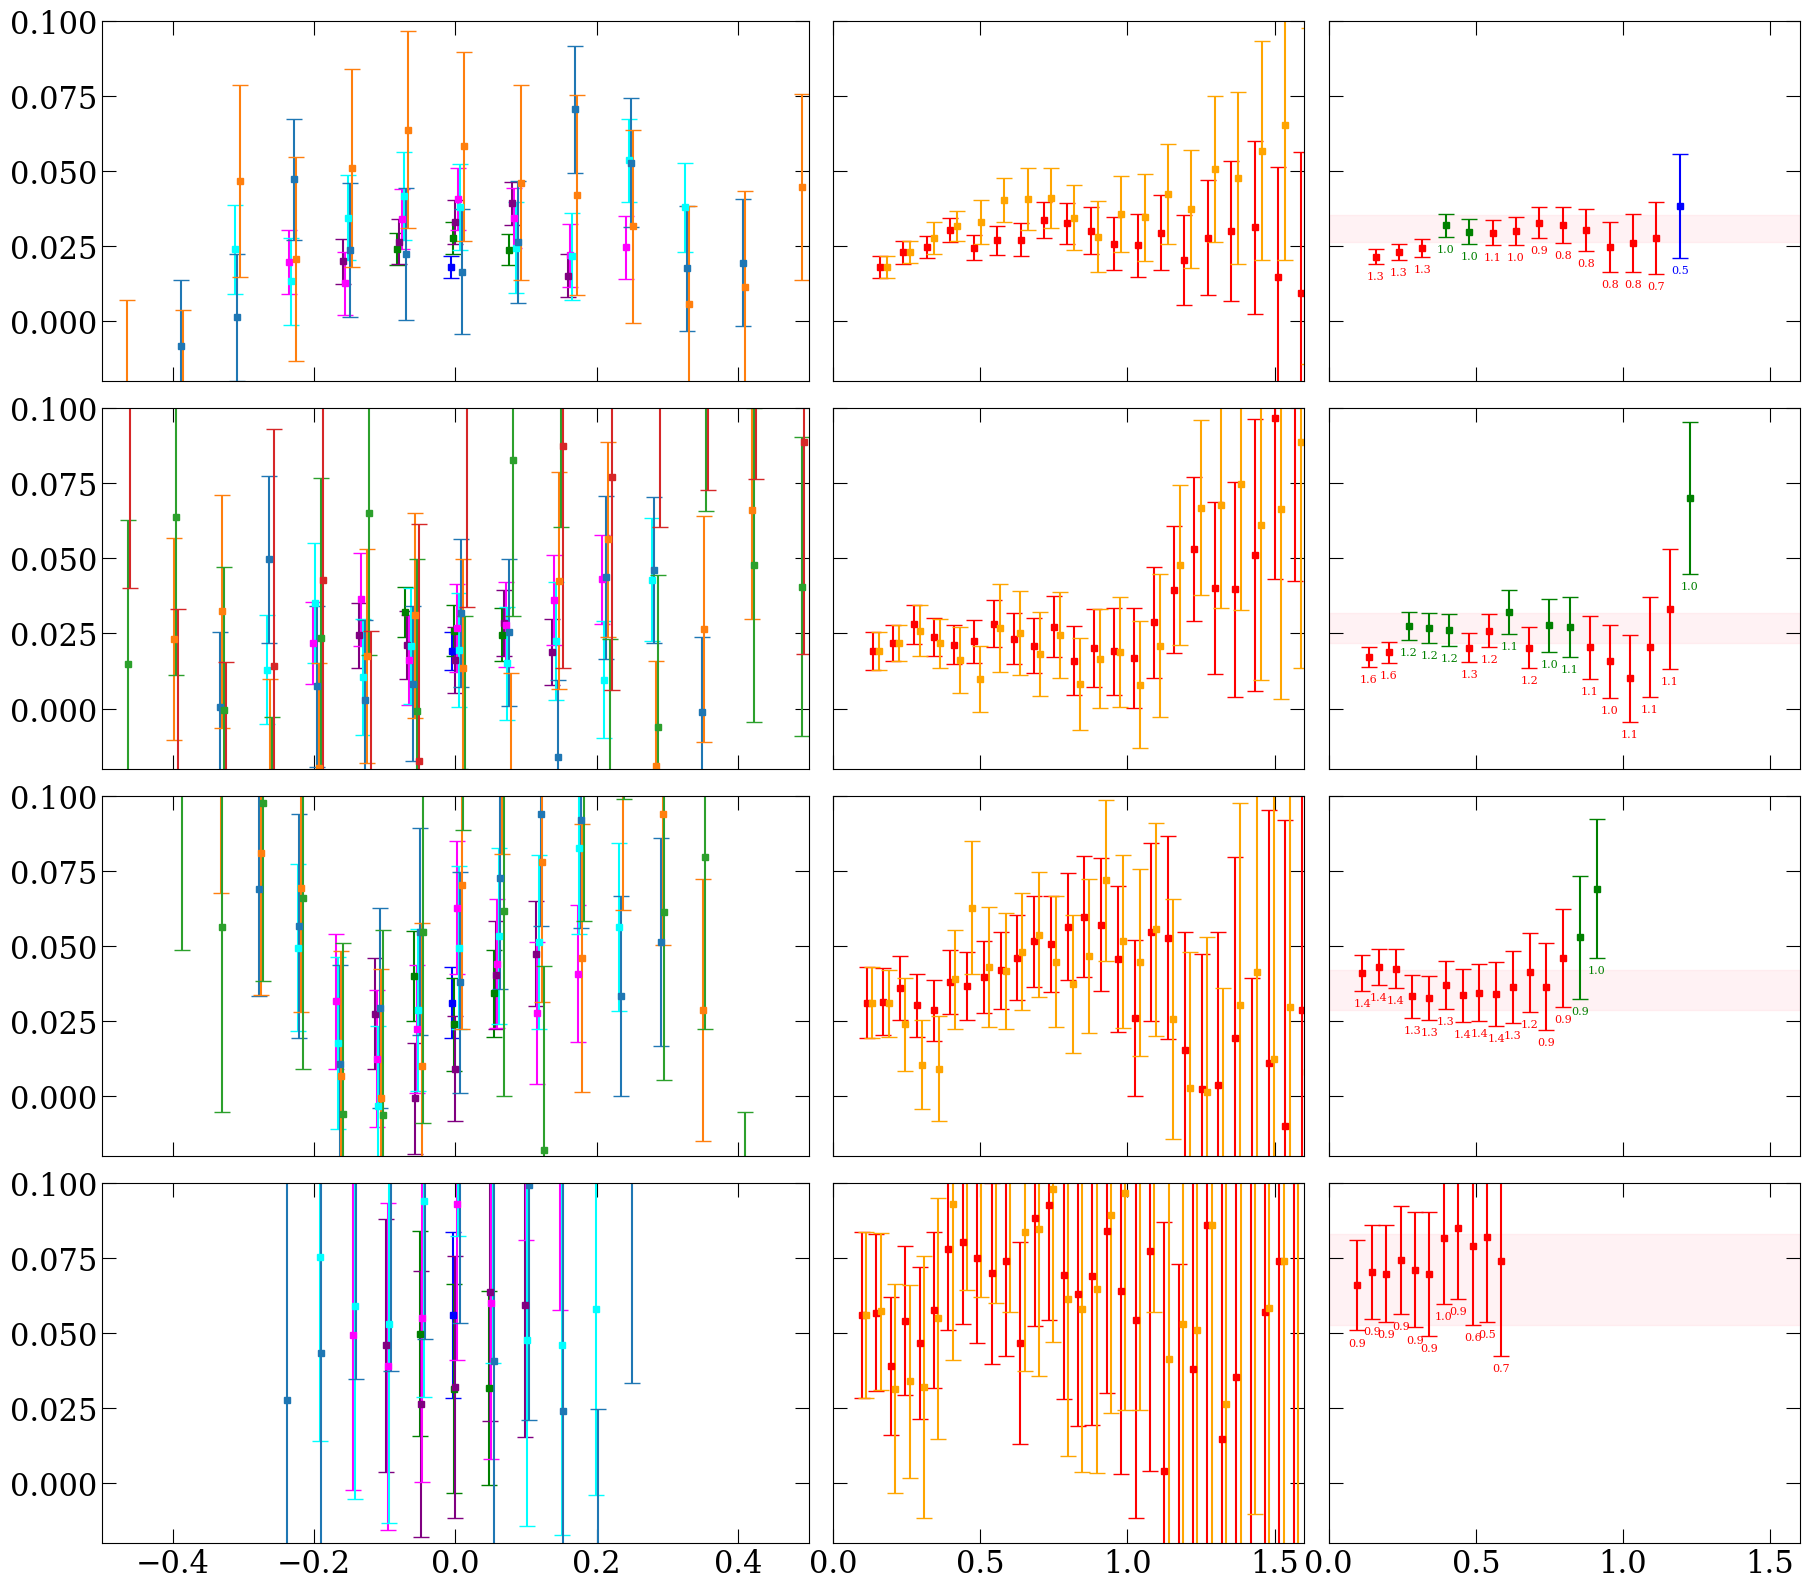

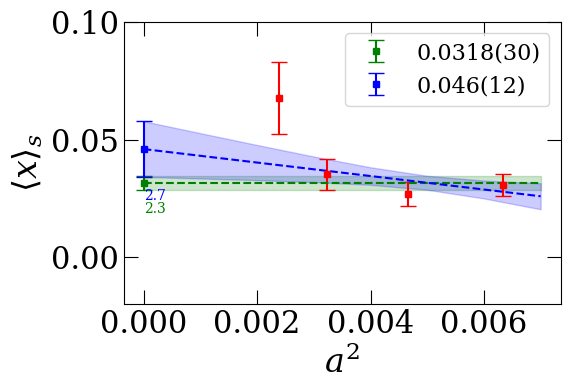

In [4]:
enss_plt=['b','c','d','e']

xlim0=[-0.5,0.5]
xlim1=[0,1.6]
xlim2=[0,1.6]
xlim3=[0,1.6]

ylim=[0,0.08]
ylim=[-0.02,0.1]

fix, axs = yu.getFigAxs(len(enss_plt),3,Lrow=4,Lcol=6,sharex='col',sharey=True, gridspec_kw={'width_ratios': [3, 2, 2]})
axs[0,0].set_xlim(xlim0)
axs[0,1].set_xlim(xlim1)
axs[0,2].set_xlim(xlim2)
axs[0,0].set_ylim(ylim)

symmetrizeQ=False

ens2Z=ens2Z_1d_V
j='js'

res={}; res2={}
for i_ens,ens in enumerate(enss_plt):
    xunit=ens2a[ens]; yunit=ens2Z[ens]
    tfs=ens2tfs[ens]

    tfs_fit=[tf for tf in tfs]
    cN1=np.real(data[ens]['N1'])
    c3ptDic={tf:np.real(data[ens]['P4i'][j][tf]/(1j*2*np.pi/ens2N[ens])) for tf in tfs}
    if symmetrizeQ:
        c3ptDic={tf:(c3ptDic[tf]+c3ptDic[tf][:,::-1])/2 for tf in tfs}
    ratioDic={tf:c3ptDic[tf]/cN1[:,tf:tf+1] for tf in tfs}

    # for tf in tfs:
    #     error=0.3
    #     shape=ratioDic[tf].shape
    #     t=yu.jackknife(np.random.randn(*shape)*error)
    #     ratioDic[tf]+=t
    
    tfmax_cut=find_t_cloest(ens,1.2)
    if ens=='d':
        tfmax_cut=find_t_cloest(ens,0.9)
    if ens=='e':
        tfmax_cut=find_t_cloest(ens,0.6)

    ax=axs[i_ens,0]
    colors=['b','orange','g','r','purple','brown','magenta','gold','cyan']
    colors_tcmin=['r','g','b','orange','purple']
    t_cut=1
    for i_tf,tf in enumerate(tfs_fit):
        if tf%2!=0 or tf>tfmax_cut:
            continue
        ratio=ratioDic[tf]
        mean,err=yu.jackme(ratio)
        tcs=np.arange(t_cut,tf-t_cut+1)
        plt_x=(tcs-tf/2+0.02*(tf-6))*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
        # plt_x=(tcs-tf/2)*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
        ax.errorbar(plt_x,plt_y,plt_yerr,color=colors[i_tf] if i_tf<len(colors) else None)
        
    # tfmax_cut=find_t_cloest(ens,1.2)

    # tc_cut=find_t_cloest(ens,0.05)
    # tfmax_cut=find_t_cloest(ens,1.5)
    print(ens,tfmax_cut)
    
    tcmins=[1,2,3,4]
    ax=axs[i_ens,1]
    for i_tcmin, tcmin in enumerate(tcmins):
        if tcmin not in [1,4]:
            continue
        for i_tf,tf in enumerate(tfs_fit):
            # if tf<tcmin*2:
            #     continue
            ratio=ratioDic[tf]
            if tf>2*tcmin:
                y_jk=ratio[:,tcmin:tf-tcmin+1]
                if symmetrizeQ:
                    y_jk=ratio[:,tcmin:tf//2+1]
                Ndata=y_jk.shape[1]
                def fitfunc(pars):
                    return list(pars)*Ndata
                pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04])
            else:
                pars_jk=ratio[:,tf//2] if tf%2==0 else (ratio[:,tf//2]+ratio[:,tf//2+1])/2
                # print(tf,pars_jk.shape)
            
            mean,err=yu.jackme(pars_jk)
            plt_x=(tf+i_tcmin*0.1)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
            ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin])  
    
    ax=axs[i_ens,2]
    fits=[]
    for i_tcmin, tcmin in enumerate(tcmins):
        tfmins=[tf for tf in tfs_fit[:-3] if tf>=2*tcmin and tf<=tfmax_cut]
        for tfmin in tfmins:
            if tfmin<tcmin*2:
                continue
            y_jk=np.concatenate([ratioDic[tf][:,tcmin:tf-tcmin+1] for tf in tfs_fit if tf>=tfmin and tf<=tfmax_cut],axis=1)
            if symmetrizeQ:
                y_jk=np.concatenate([ratioDic[tf][:,tcmin:tf//2+1] for tf in tfs_fit if tf>=tfmin and tf<=tfmax_cut],axis=1)

            Ndata=y_jk.shape[1]
            def fitfunc(pars):
                return list(pars)*Ndata
            # pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04],mask='uncorrelated')
            pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04])
            fits.append([(tcmin,tfmin),pars_jk,chi2_jk,Ndof])
    
    tfmins=list(set([fit[0][1] for fit in fits])); tfmins.sort()
    for tfmin in tfmins:
        t=[fit for fit in fits if fit[0][1]==tfmin]
        pars_jk,props_jk=yu.jackMA(t)
        ind_mpf=np.argmax(np.mean(props_jk,axis=0))
        fitlabel,pars_jk,chi2_jk,Ndof=t[ind_mpf]
        i_tcmin=tcmins.index(fitlabel[0])
        
        mean,err=yu.jackme(pars_jk[:,0])
        plt_x=(tfmin)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
        i_tf=tfs_fit.index(tfmin)
        ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin]) 
        
        chi2R=np.mean(chi2_jk)/Ndof
        ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/24
        ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_yerr-chi2_shift),color=colors_tcmin[i_tcmin],size=8,ha='center')       
        
    pars_jk,props_jk=yu.jackMA(fits)
    # ind_mpf=np.argmax(np.mean(props_jk,axis=0))
    pars_mean,pars_err=yu.jackme(pars_jk)
    res2[ens]=[pars_mean[0],pars_err[0]]
    for icol in [2]:
        ax.set_xlim(ax.get_xlim())
        ax=axs[i_ens,icol]
        
        plt_x=ax.get_xlim(); plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
        ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='pink',alpha=0.2)    
        
        if icol==0:
            print(ens,yu.un2str(plt_y,plt_err))

plt.tight_layout()

fix, axs = yu.getFigAxs(1,1,Lrow=4,Lcol=6,sharex=True,sharey=True)
ax=axs[0,0]
ax.set_ylim(ylim)

a2s=np.array([ens2a[ens]**2 for ens in enss])
gs_m=np.array([res2[ens][0]*ens2Z[ens] for ens in enss])
gs_e=np.array([res2[ens][1]*ens2Z[ens] for ens in enss])

ax.errorbar(a2s,gs_m,gs_e,color='r') 

mean=gs_m; err=gs_e
def fitfunc(a2,g):
    return g+0*a2
popt,pcov=curve_fit(fitfunc,a2s,mean,sigma=err,absolute_sigma=True)
r=fitfunc(a2s,*popt)-mean
color='g'
chi2R=r.T @ np.linalg.inv(np.diag(err**2)) @ r / (len(enss)-1)
a2s2=np.arange(0,0.008,0.001)

mean,err,cov=yu.propagateError(lambda pars:fitfunc(a2s2,*pars), popt, pcov)
ax.plot(a2s2,mean,'--',color=color)
ax.fill_between(a2s2,mean-err,mean+err,color=color,alpha=0.2)
ax.errorbar([0],[popt[0]],np.sqrt(pcov[0,0]),color=color, label=yu.un2str(popt[0],np.sqrt(pcov[0,0])))
ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
ax.annotate("%0.1f" %chi2R,(0,popt[0]-np.sqrt(pcov[0,0])-chi2_shift),color=color)

print('c.l._const',yu.un2str(popt[0],np.sqrt(pcov[0,0])))

mean=gs_m; err=gs_e
def fitfunc(a2,g,c):
    return g+c*a2
popt,pcov=curve_fit(fitfunc,a2s,mean,sigma=err,absolute_sigma=True)
r=fitfunc(a2s,*popt)-mean
color='b'
chi2R=r.T @ np.linalg.inv(np.diag(err**2)) @ r / (len(enss)-2)
a2s2=np.arange(0,0.008,0.001)

mean,err,cov=yu.propagateError(lambda pars:fitfunc(a2s2,*pars), popt, pcov)
ax.plot(a2s2,mean,'--',color=color)
ax.fill_between(a2s2,mean-err,mean+err,color=color,alpha=0.2)
ax.errorbar([0],[popt[0]],np.sqrt(pcov[0,0]),color=color, label=yu.un2str(popt[0],np.sqrt(pcov[0,0])))
ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
ax.annotate("%0.1f" %chi2R,(0,popt[0]-np.sqrt(pcov[0,0])-chi2_shift),color=color)

print('c.l._linear',yu.un2str(popt[0],np.sqrt(pcov[0,0])))

ax.legend(fontsize=16)
ax.set_xlabel(r'$a^2$')
ax.set_ylabel(r'$\langle x \rangle _s$')

plt.tight_layout()
plt.savefig('fig/xs.pdf')

b 15
b 0.0312(38)
c 18
c 0.0289(52)
d 21
d 0.054(14)
e 25
e 0.081(58)
c.l._const 0.0317(30)
c.l._linear 0.045(18)


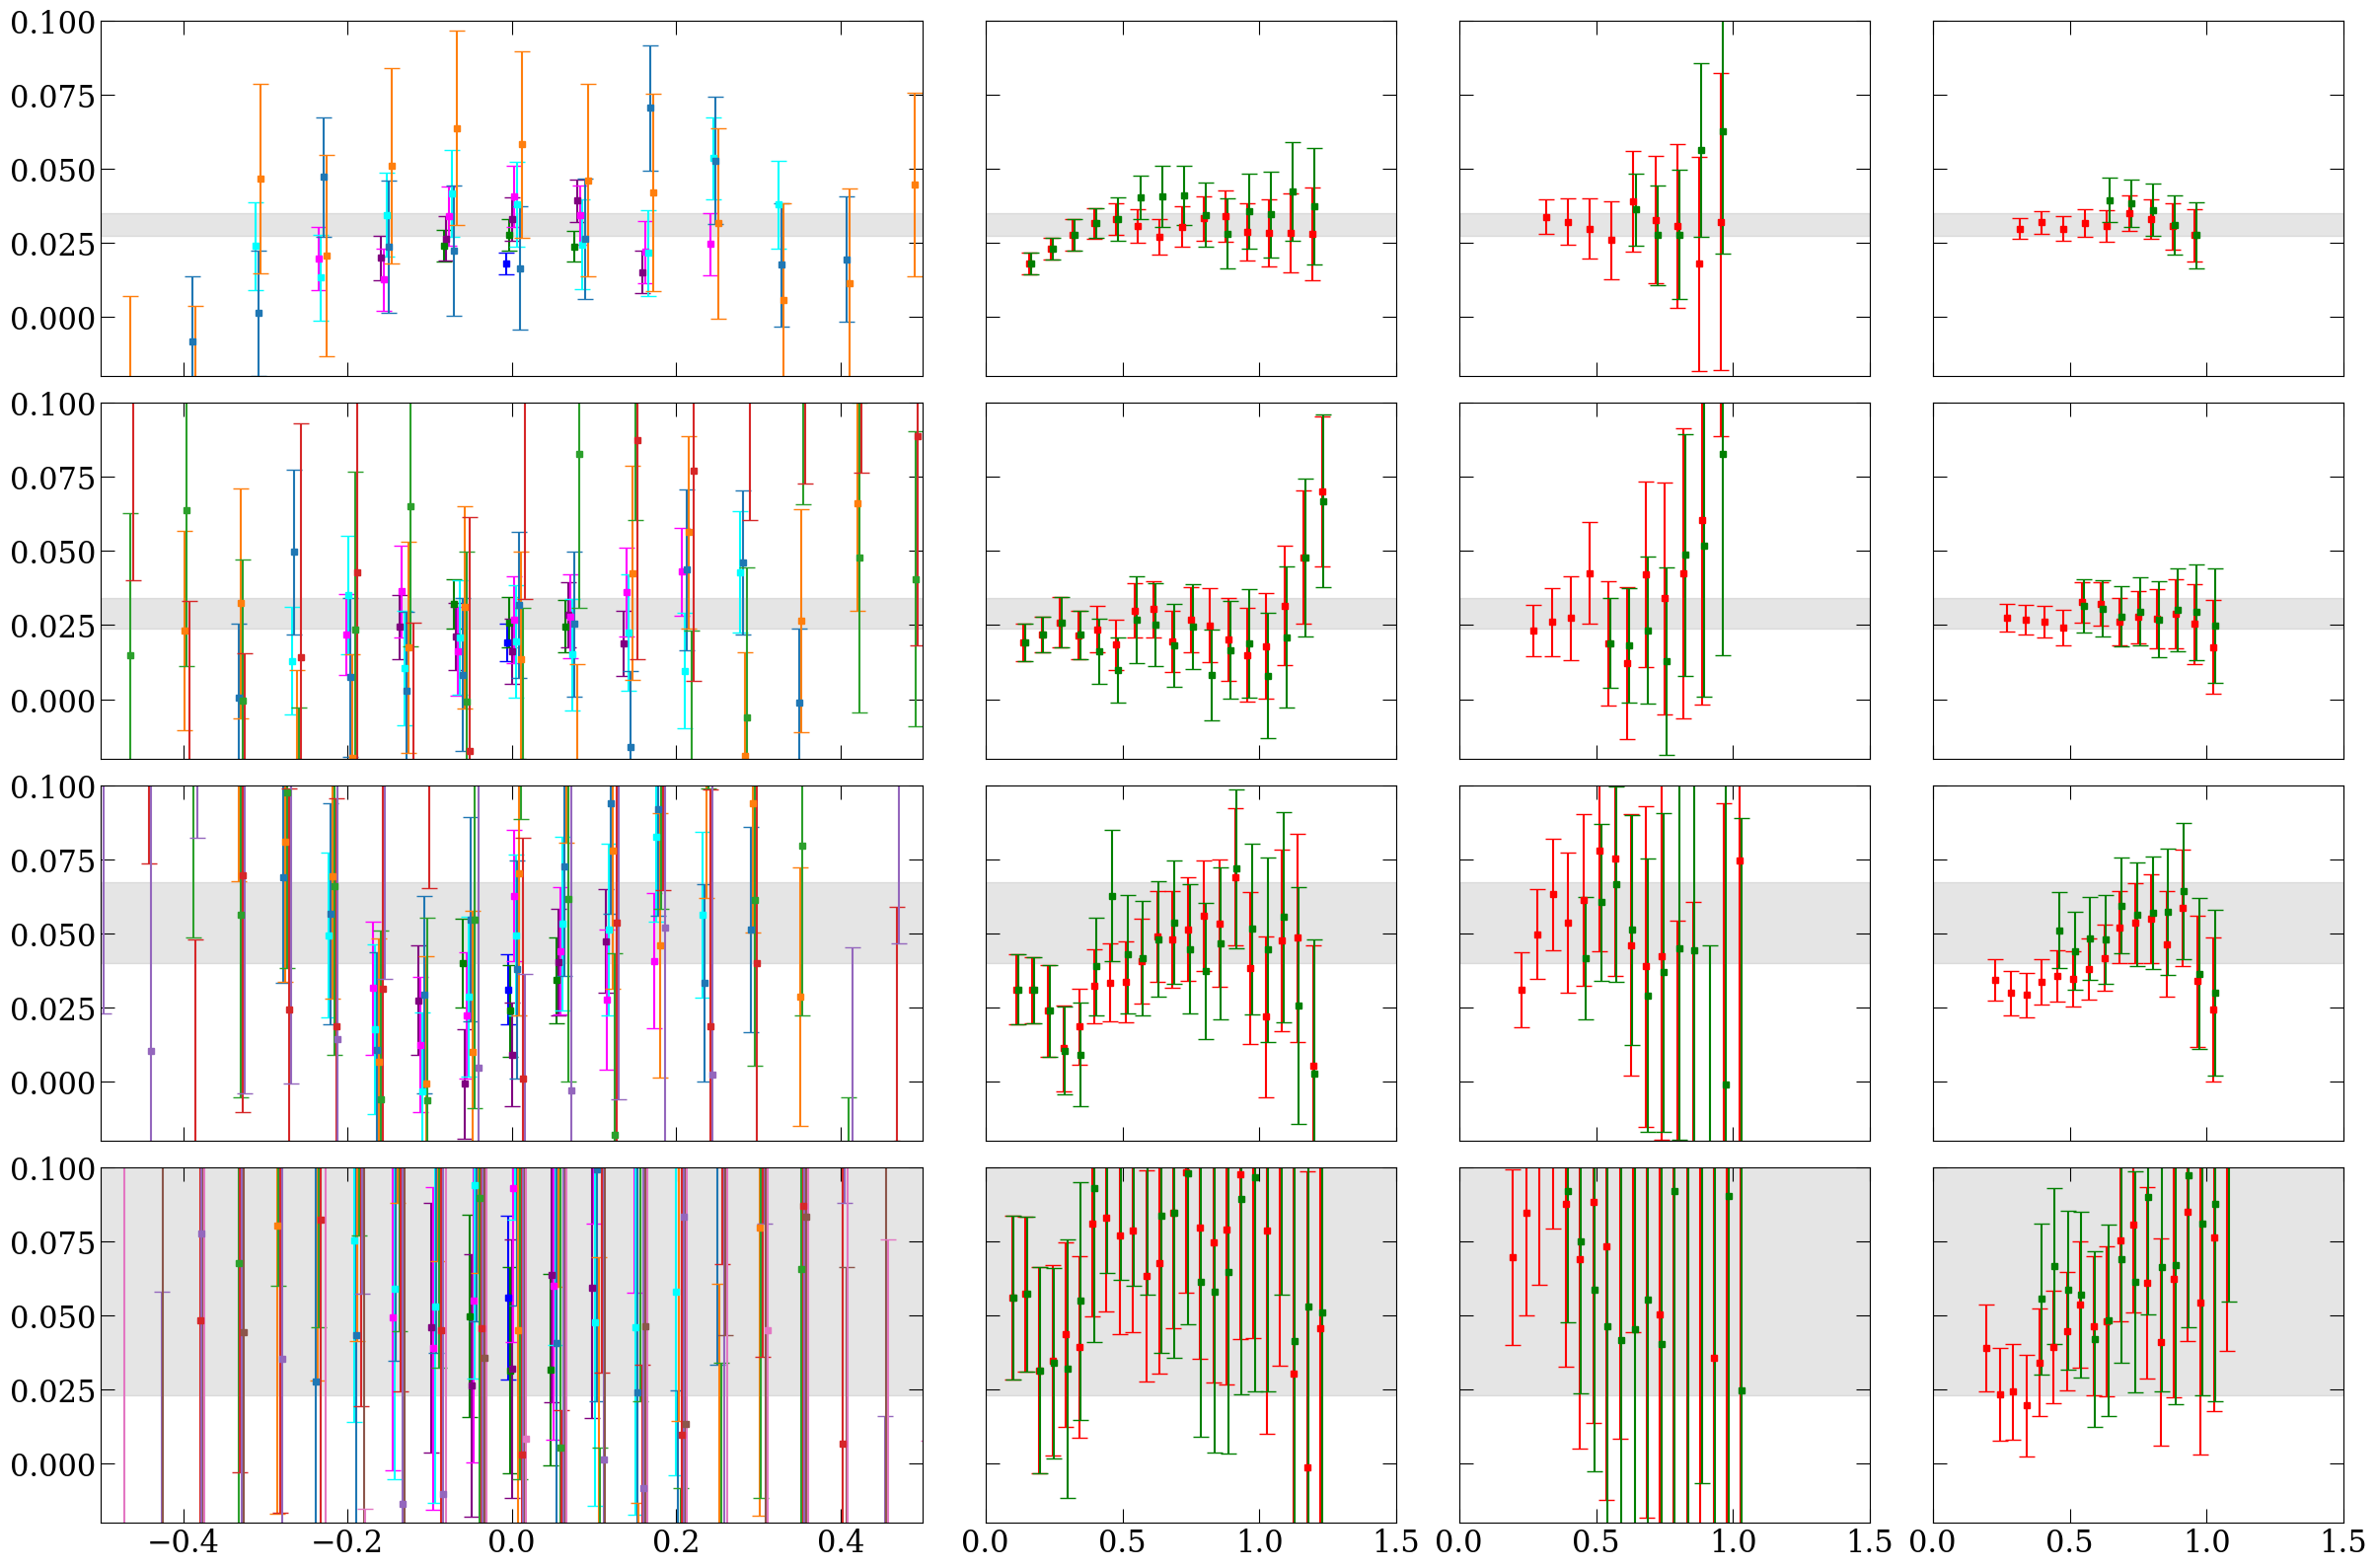

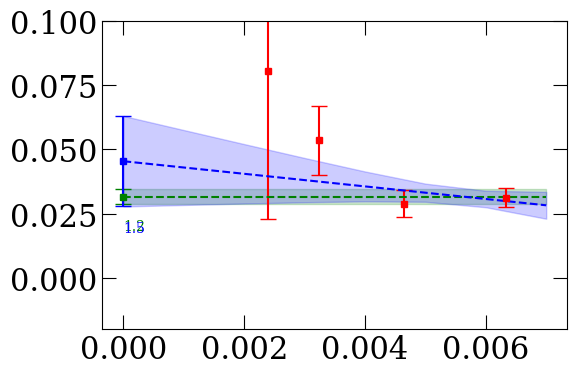

In [5]:
enss_plt=['b','c','d','e']

xlim0=[-0.5,0.5]
xlim1=[0,1.5]
xlim2=[0,1.5]
xlim3=[0,1.5]

ylim=[0,0.08]
ylim=[-0.02,0.1]

fix, axs = yu.getFigAxs(len(enss_plt),4,Lrow=4,Lcol=6,sharex='col',sharey=True, gridspec_kw={'width_ratios': [2, 1, 1, 1]})
axs[0,0].set_xlim(xlim0)
axs[0,1].set_xlim(xlim1)
axs[0,2].set_xlim(xlim2)
axs[0,3].set_xlim(xlim3)
axs[0,0].set_ylim(ylim)

symmetrizeQ=False

ens2Z=ens2Z_1d_V
j='js'

res={}
for i_ens,ens in enumerate(enss_plt):
    xunit=ens2a[ens]; yunit=ens2Z[ens]
    tfs=ens2tfs[ens]
    
    tfmax_cut=find_t_cloest(ens,1.2)

    # tc_cut=find_t_cloest(ens,0.05)
    # tfmax_cut=find_t_cloest(ens,1.5)
    print(ens,tfmax_cut)
    
    tfs_fit=[tf for tf in tfs if tf<=tfmax_cut]
    cN1=np.real(data[ens]['N1'])
    c3ptDic={tf:np.real(data[ens]['P4i'][j][tf]/(1j*2*np.pi/ens2N[ens])) for tf in tfs}
    if symmetrizeQ:
        c3ptDic={tf:(c3ptDic[tf]+c3ptDic[tf][:,::-1])/2 for tf in tfs}
    ratioDic={tf:c3ptDic[tf]/cN1[:,tf:tf+1] for tf in tfs}

    ax=axs[i_ens,0]
    colors=['b','orange','g','r','purple','brown','magenta','gold','cyan']
    colors_tcmin=['r','g','b','orange','purple']
    t_cut=1
    for i_tf,tf in enumerate(tfs_fit):
        if tf%2!=0:
            continue
        ratio=ratioDic[tf]
        mean,err=yu.jackme(ratio)
        tcs=np.arange(t_cut,tf-t_cut+1)
        plt_x=(tcs-tf/2+0.02*(tf-6))*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
        # plt_x=(tcs-tf/2)*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
        ax.errorbar(plt_x,plt_y,plt_yerr,color=colors[i_tf] if i_tf<len(colors) else None)
    
    tcmins=[2,4]
    ax=axs[i_ens,1]
    for i_tcmin, tcmin in enumerate(tcmins):
        for i_tf,tf in enumerate(tfs_fit):
            # if tf<tcmin*2:
            #     continue
            ratio=ratioDic[tf]
            if tf>2*tcmin:
                y_jk=ratio[:,tcmin:tf-tcmin+1]
                if symmetrizeQ:
                    y_jk=ratio[:,tcmin:tf//2+1]
                Ndata=y_jk.shape[1]
                def fitfunc(pars):
                    return list(pars)*Ndata
                pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04])
            else:
                pars_jk=ratio[:,tf//2] if tf%2==0 else (ratio[:,tf//2]+ratio[:,tf//2+1])/2
                # print(tf,pars_jk.shape)
            
            mean,err=yu.jackme(pars_jk)
            plt_x=(tf+i_tcmin*0.1)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
            ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin])  
            
    ax=axs[i_ens,2]
    for i_tcmin, tcmin in enumerate(tcmins):
        tfmins=[tf for tf in tfs_fit[:-3] if tf>=2*tcmin]
        ratioSummedDic={tf:np.sum(ratioDic[tf][:,tcmin:tf-tcmin+1],axis=1) for tf in tfs}
        for tfmin in tfmins:
            if tfmin<tcmin*2:
                continue
            y_jk=np.transpose([ratioSummedDic[tf] for tf in tfs_fit if tf>=tfmin])
            Ndata=y_jk.shape[1]
            def fitfunc(pars):
                g,c=pars
                return g*np.arange(Ndata)+c
            pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04,1])
            
            mean,err=yu.jackme(pars_jk[:,0])
            plt_x=(tfmin+i_tcmin*0.1)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
            i_tf=tfs_fit.index(tfmin)
            ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin])
        
    ax=axs[i_ens,3]
    fits=[]
    for i_tcmin, tcmin in enumerate(tcmins):
        tfmins=[tf for tf in tfs_fit[:-3] if tf>=2*tcmin]
        for tfmin in tfmins:
            if tfmin<tcmin*2:
                continue
            y_jk=np.concatenate([ratioDic[tf][:,tcmin:tf-tcmin+1] for tf in tfs_fit if tf>=tfmin],axis=1)
            if symmetrizeQ:
                y_jk=np.concatenate([ratioDic[tf][:,tcmin:tf//2+1] for tf in tfs_fit if tf>=tfmin],axis=1)

            Ndata=y_jk.shape[1]
            def fitfunc(pars):
                return list(pars)*Ndata
            # pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04],mask='uncorrelated')
            pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04])
            fits.append([tfmin,pars_jk,chi2_jk,Ndof])
            
            mean,err=yu.jackme(pars_jk[:,0])
            plt_x=(tfmin+i_tcmin*0.1)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
            i_tf=tfs_fit.index(tfmin)
            ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin]) 
        
    pars_jk,props_jk=yu.jackMA(fits)
    # ind_mpf=np.argmax(np.mean(props_jk,axis=0))
    pars_mean,pars_err=yu.jackme(pars_jk)
    res[ens]=[pars_mean[0],pars_err[0]]
    for icol in range(4):
        ax.set_xlim(ax.get_xlim())
        ax=axs[i_ens,icol]
        
        plt_x=ax.get_xlim(); plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
        ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='grey',alpha=0.2)    
        
        if icol==0:
            print(ens,yu.un2str(plt_y,plt_err))

plt.tight_layout()

fix, axs = yu.getFigAxs(1,1,Lrow=4,Lcol=6)
ax=axs[0,0]
ax.set_ylim(ylim)

a2s=np.array([ens2a[ens]**2 for ens in enss])
gs_m=np.array([res[ens][0]*ens2Z[ens] for ens in enss])
gs_e=np.array([res[ens][1]*ens2Z[ens] for ens in enss])

ax.errorbar(a2s,gs_m,gs_e,color='r') 

mean=gs_m; err=gs_e
def fitfunc(a2,g):
    return g+0*a2
popt,pcov=curve_fit(fitfunc,a2s,mean,sigma=err,absolute_sigma=True)
r=fitfunc(a2s,*popt)-mean
color='g'
chi2R=r.T @ np.linalg.inv(np.diag(err**2)) @ r / (len(enss)-1)
a2s2=np.arange(0,0.008,0.001)

mean,err,cov=yu.propagateError(lambda pars:fitfunc(a2s2,*pars), popt, pcov)
ax.plot(a2s2,mean,'--',color=color)
ax.fill_between(a2s2,mean-err,mean+err,color=color,alpha=0.2)
ax.errorbar([0],[popt[0]],np.sqrt(pcov[0,0]),color=color)
ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
ax.annotate("%0.1f" %chi2R,(0,popt[0]-np.sqrt(pcov[0,0])-chi2_shift),color=color)

print('c.l._const',yu.un2str(popt[0],np.sqrt(pcov[0,0])))

mean=gs_m; err=gs_e
def fitfunc(a2,g,c):
    return g+c*a2
popt,pcov=curve_fit(fitfunc,a2s,mean,sigma=err,absolute_sigma=True)
r=fitfunc(a2s,*popt)-mean
color='b'
chi2R=r.T @ np.linalg.inv(np.diag(err**2)) @ r / (len(enss)-2)
a2s2=np.arange(0,0.008,0.001)

mean,err,cov=yu.propagateError(lambda pars:fitfunc(a2s2,*pars), popt, pcov)
ax.plot(a2s2,mean,'--',color=color)
ax.fill_between(a2s2,mean-err,mean+err,color=color,alpha=0.2)
ax.errorbar([0],[popt[0]],np.sqrt(pcov[0,0]),color=color)
ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
ax.annotate("%0.1f" %chi2R,(0,popt[0]-np.sqrt(pcov[0,0])-chi2_shift),color=color)

print('c.l._linear',yu.un2str(popt[0],np.sqrt(pcov[0,0])))

b 3 19


b 0.0339(51)
c 3 22
c 0.0294(69)
d 4 26
d 0.027(19)
c.l. 0.0321(40)


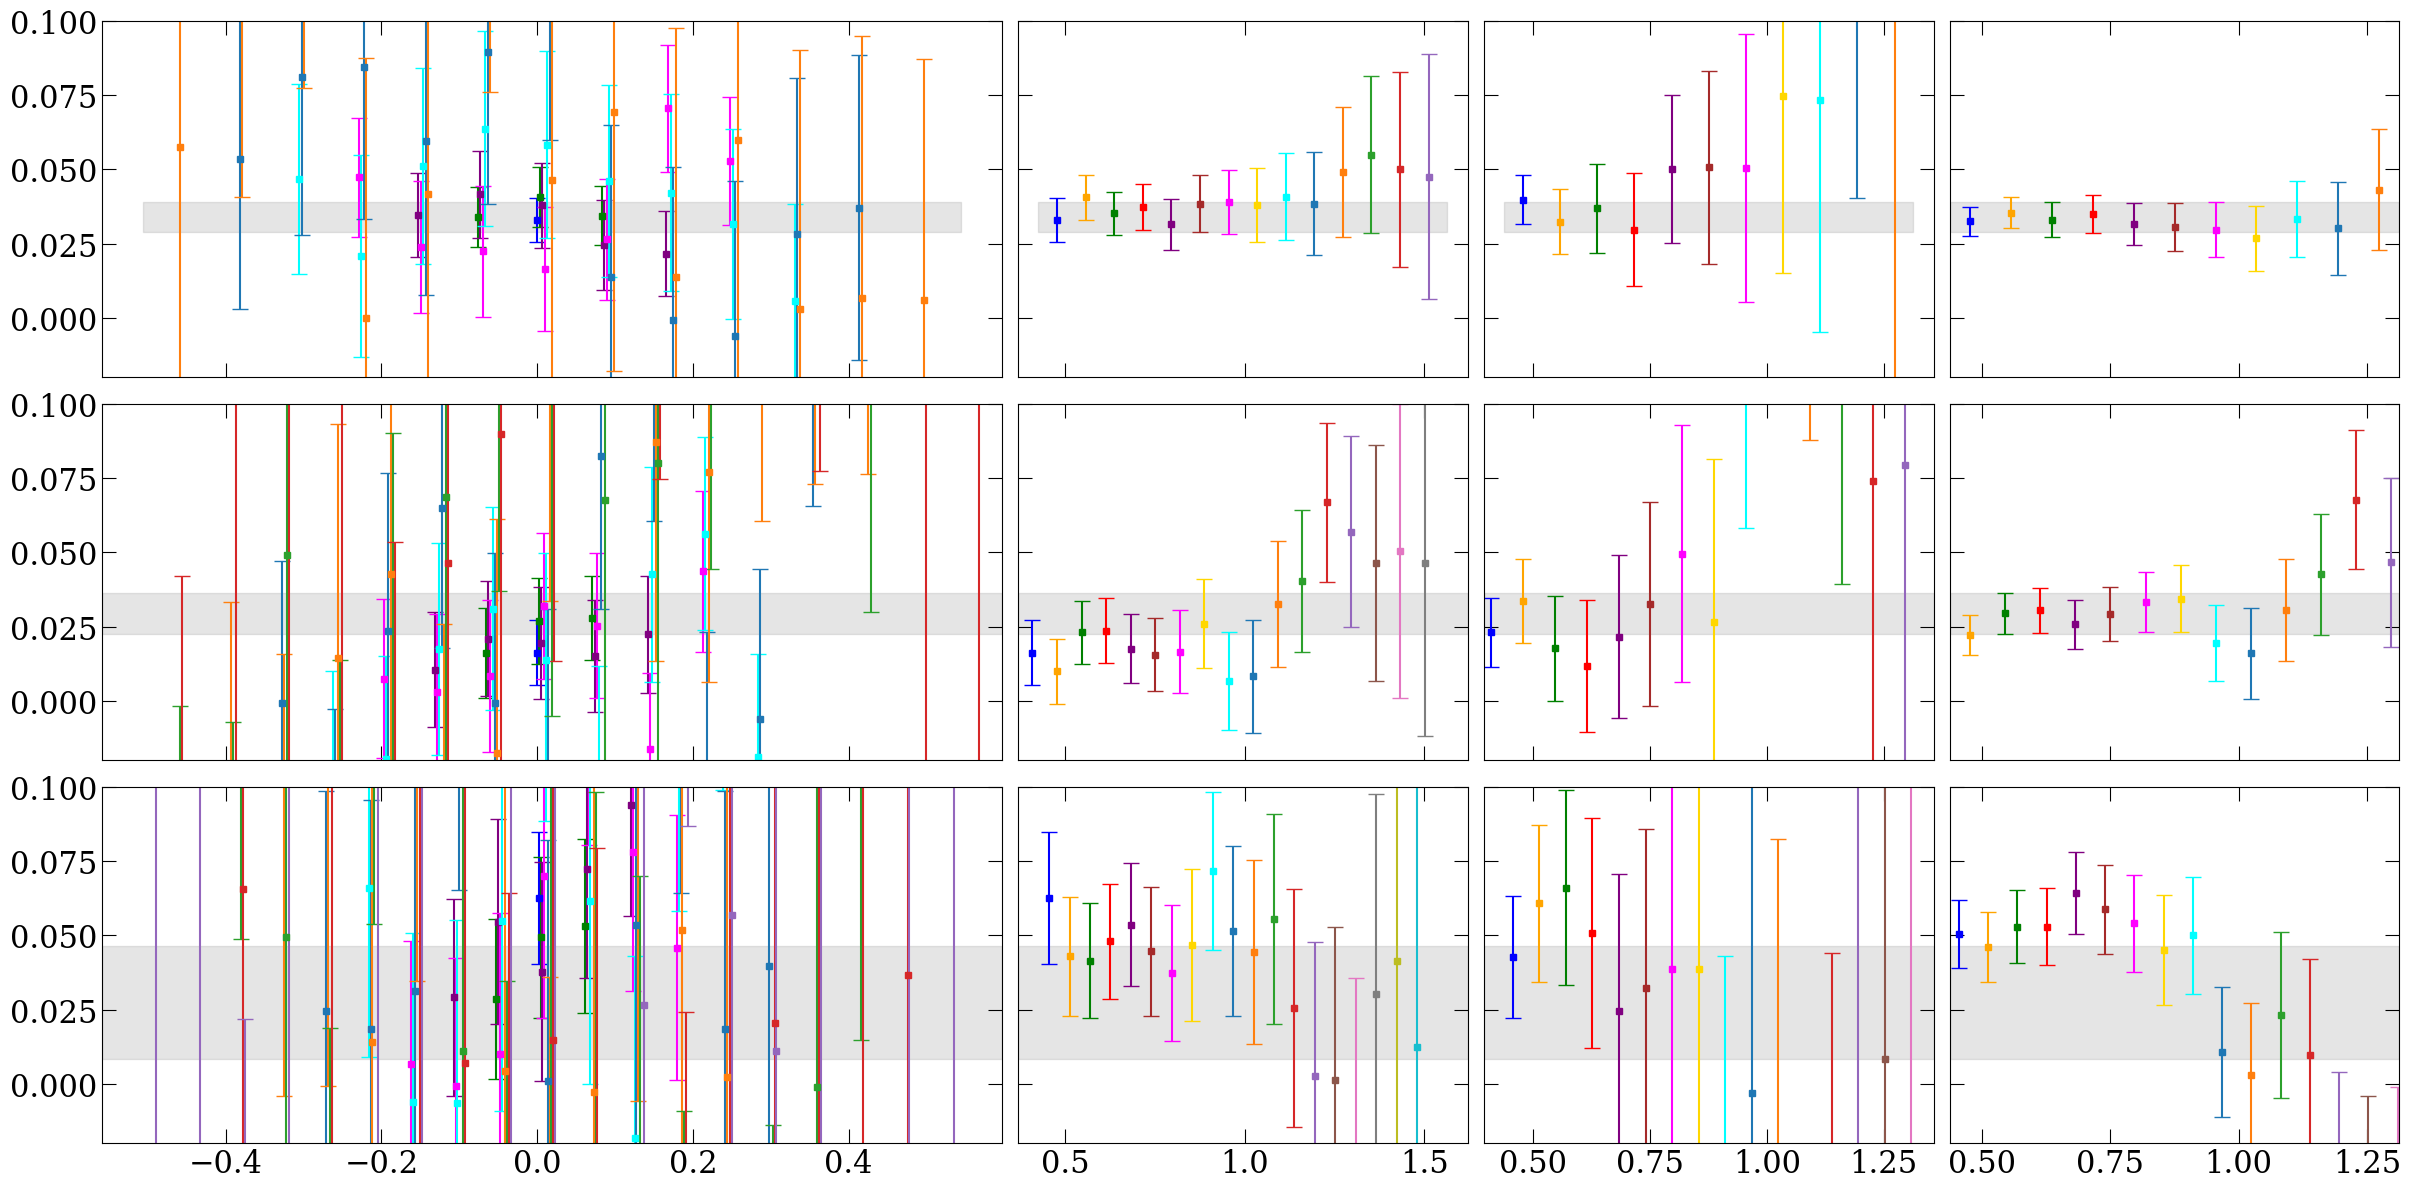

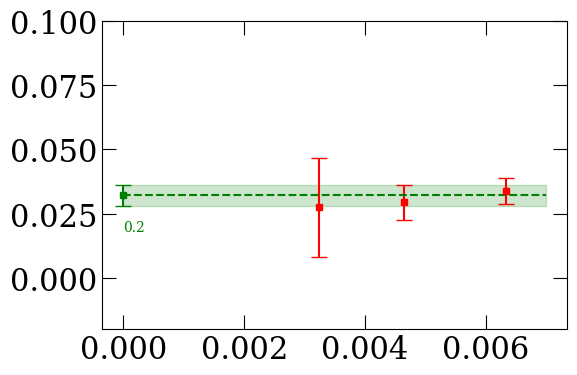

In [ ]:
enss_plt=['b','c','d']

ylim=[0,0.08]
ylim=[-0.02,0.1]

fix, axs = yu.getFigAxs(len(enss_plt),4,Lrow=4,Lcol=6,sharex='col',sharey=True, gridspec_kw={'width_ratios': [2, 1, 1, 1]})
axs[0,0].set_ylim(ylim)

symmetrizeQ=False

ens2Z=ens2Z_1d_V
j='js'

res={}
for i_ens,ens in enumerate(enss_plt):
    xunit=ens2a[ens]; yunit=ens2Z[ens]
    tfs=ens2tfs[ens]
    
    tc_cut=find_t_cloest(ens,0.2)
    tfmax_cut=find_t_cloest(ens,1.5)
    print(ens,tc_cut,tfmax_cut)
    
    tfs_fit=[tf for tf in tfs if tc_cut*2<=tf<=tfmax_cut]
    cN1=np.real(data[ens]['N1'])
    c3ptDic={tf:np.real(data[ens]['P4i'][j][tf]/(1j*2*np.pi/ens2N[ens])) for tf in tfs}
    if symmetrizeQ:
        c3ptDic={tf:(c3ptDic[tf]+c3ptDic[tf][:,::-1])/2 for tf in tfs}
    ratioDic={tf:c3ptDic[tf]/cN1[:,tf:tf+1] for tf in tfs}

    ax=axs[i_ens,0]
    colors=['b','orange','g','r','purple','brown','magenta','gold','cyan']
    t_cut=tc_cut
    for i_tf,tf in enumerate(tfs_fit):
        if tf%2!=0:
            continue
        ratio=ratioDic[tf]
        mean,err=yu.jackme(ratio)
        tcs=np.arange(t_cut,tf-t_cut+1)
        plt_x=(tcs-tf/2+0.02*(tf-6))*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
        # plt_x=(tcs-tf/2)*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
        ax.errorbar(plt_x,plt_y,plt_yerr,color=colors[i_tf] if i_tf<len(colors) else None)
        
    ax=axs[i_ens,1]
    tcmin=t_cut
    for i_tf,tf in enumerate(tfs_fit):
        # if tf<tcmin*2:
        #     continue
        ratio=ratioDic[tf]
        if tf>2*tcmin:
            y_jk=ratio[:,tcmin:tf-tcmin+1]
            if symmetrizeQ:
                y_jk=ratio[:,tcmin:tf//2+1]
            Ndata=y_jk.shape[1]
            def fitfunc(pars):
                return list(pars)*Ndata
            pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04])
        else:
            pars_jk=ratio[:,tf//2] if tf%2==0 else (ratio[:,tf//2]+ratio[:,tf//2+1])/2
            # print(tf,pars_jk.shape)
        
        mean,err=yu.jackme(pars_jk)
        plt_x=tf*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
        ax.errorbar(plt_x,plt_y,plt_yerr,color=colors[i_tf] if i_tf<len(colors) else None)  
        
    ax=axs[i_ens,2]
    tfmins=[tf for tf in tfs_fit[:-3] if tf>=2*tcmin]
    ratioSummedDic={tf:np.sum(ratioDic[tf][:,tcmin:tf-tcmin+1],axis=1) for tf in tfs}
    for tfmin in tfmins:
        y_jk=np.transpose([ratioSummedDic[tf] for tf in tfs_fit if tf>=tfmin])
        Ndata=y_jk.shape[1]
        def fitfunc(pars):
            g,c=pars
            return g*np.arange(Ndata)+c
        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04,1])
        
        mean,err=yu.jackme(pars_jk[:,0])
        plt_x=tfmin*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
        i_tf=tfs_fit.index(tfmin)
        ax.errorbar(plt_x,plt_y,plt_yerr,color=colors[i_tf] if i_tf<len(colors) else None)
        
    ax=axs[i_ens,3]
    tfmins=[tf for tf in tfs_fit[:-3] if tf>=2*tcmin]
    fits=[]
    for tfmin in tfmins:
        y_jk=np.concatenate([ratioDic[tf][:,tcmin:tf-tcmin+1] for tf in tfs_fit if tf>=tfmin],axis=1)
        if symmetrizeQ:
            y_jk=np.concatenate([ratioDic[tf][:,tcmin:tf//2+1] for tf in tfs_fit if tf>=tfmin],axis=1)

        Ndata=y_jk.shape[1]
        def fitfunc(pars):
            return list(pars)*Ndata
        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04])
        fits.append([tfmin,pars_jk,chi2_jk,Ndof])
        
        mean,err=yu.jackme(pars_jk[:,0])
        plt_x=tfmin*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
        i_tf=tfs_fit.index(tfmin)
        ax.errorbar(plt_x,plt_y,plt_yerr,color=colors[i_tf] if i_tf<len(colors) else None) 
    
    pars_jk,props_jk=yu.jackMA(fits)
    # ind_mpf=np.argmax(np.mean(props_jk,axis=0))
    pars_mean,pars_err=yu.jackme(pars_jk)
    res[ens]=[pars_mean[0],pars_err[0]]
    for icol in range(4):
        ax.set_xlim(ax.get_xlim())
        ax=axs[i_ens,icol]
        
        plt_x=ax.get_xlim(); plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
        ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='grey',alpha=0.2)    
        
        if icol==0:
            print(ens,yu.un2str(plt_y,plt_err))

plt.tight_layout()

fix, axs = yu.getFigAxs(1,1,Lrow=4,Lcol=6)
ax=axs[0,0]
ax.set_ylim(ylim)

a2s=np.array([ens2a[ens]**2 for ens in enss])
gs_m=np.array([res[ens][0]*ens2Z[ens] for ens in enss])
gs_e=np.array([res[ens][1]*ens2Z[ens] for ens in enss])

ax.errorbar(a2s,gs_m,gs_e,color='r') 

mean=gs_m; err=gs_e
def fitfunc(a2,g):
    return g+0*a2
popt,pcov=curve_fit(fitfunc,a2s,mean,sigma=err,absolute_sigma=True)
r=fitfunc(a2s,*popt)-mean
color='g'
chi2R=r.T @ np.linalg.inv(np.diag(err**2)) @ r / (len(enss)-1)
a2s2=np.arange(0,0.008,0.001)
res=fitfunc(a2s2,*popt)
ax.plot(a2s2,res,'--',color=color)
ax.fill_between(a2s2,res-[np.sqrt(pcov[0,0])]*len(a2s2),res+[np.sqrt(pcov[0,0])]*len(a2s2),color=color,alpha=0.2)
ax.errorbar([0],[popt[0]],np.sqrt(pcov[0,0]),color=color)
ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
ax.annotate("%0.1f" %chi2R,(0,popt[0]-np.sqrt(pcov[0,0])-chi2_shift),color=color)

print('c.l.',yu.un2str(popt[0],np.sqrt(pcov[0,0])))

# def fitfunc(a2,g,c):
#     return g+c*a2
# popt,pcov=curve_fit(fitfunc,a2s,mean,sigma=err,absolute_sigma=True)
# r=fitfunc(a2s,*popt)-mean
# color='b'
# chi2R=r.T @ np.linalg.inv(np.diag(err**2)) @ r / (len(enss)-1)
# a2s2=np.arange(0,0.008,0.001)
# res=fitfunc(a2s2,*popt)
# ax.plot(a2s2,res,'r-')

# ax.fill_between(a2s2,res-[np.sqrt(pcov[0,0])]*len(a2s2),res+[np.sqrt(pcov[0,0])]*len(a2s2),color='r',alpha=0.2)
# ax.errorbar([0],[popt[0]],np.sqrt(pcov[0,0]),color=color)
# ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
# ax.annotate("%0.1f" %chi2R,(0,popt[0]-np.sqrt(pcov[0,0])-chi2_shift),color=color)

b 5 19
b 0.028(11)
c 6 22
c 0.050(17)
d 7 26
d 0.064(29)
c.l. 0.0372(88)


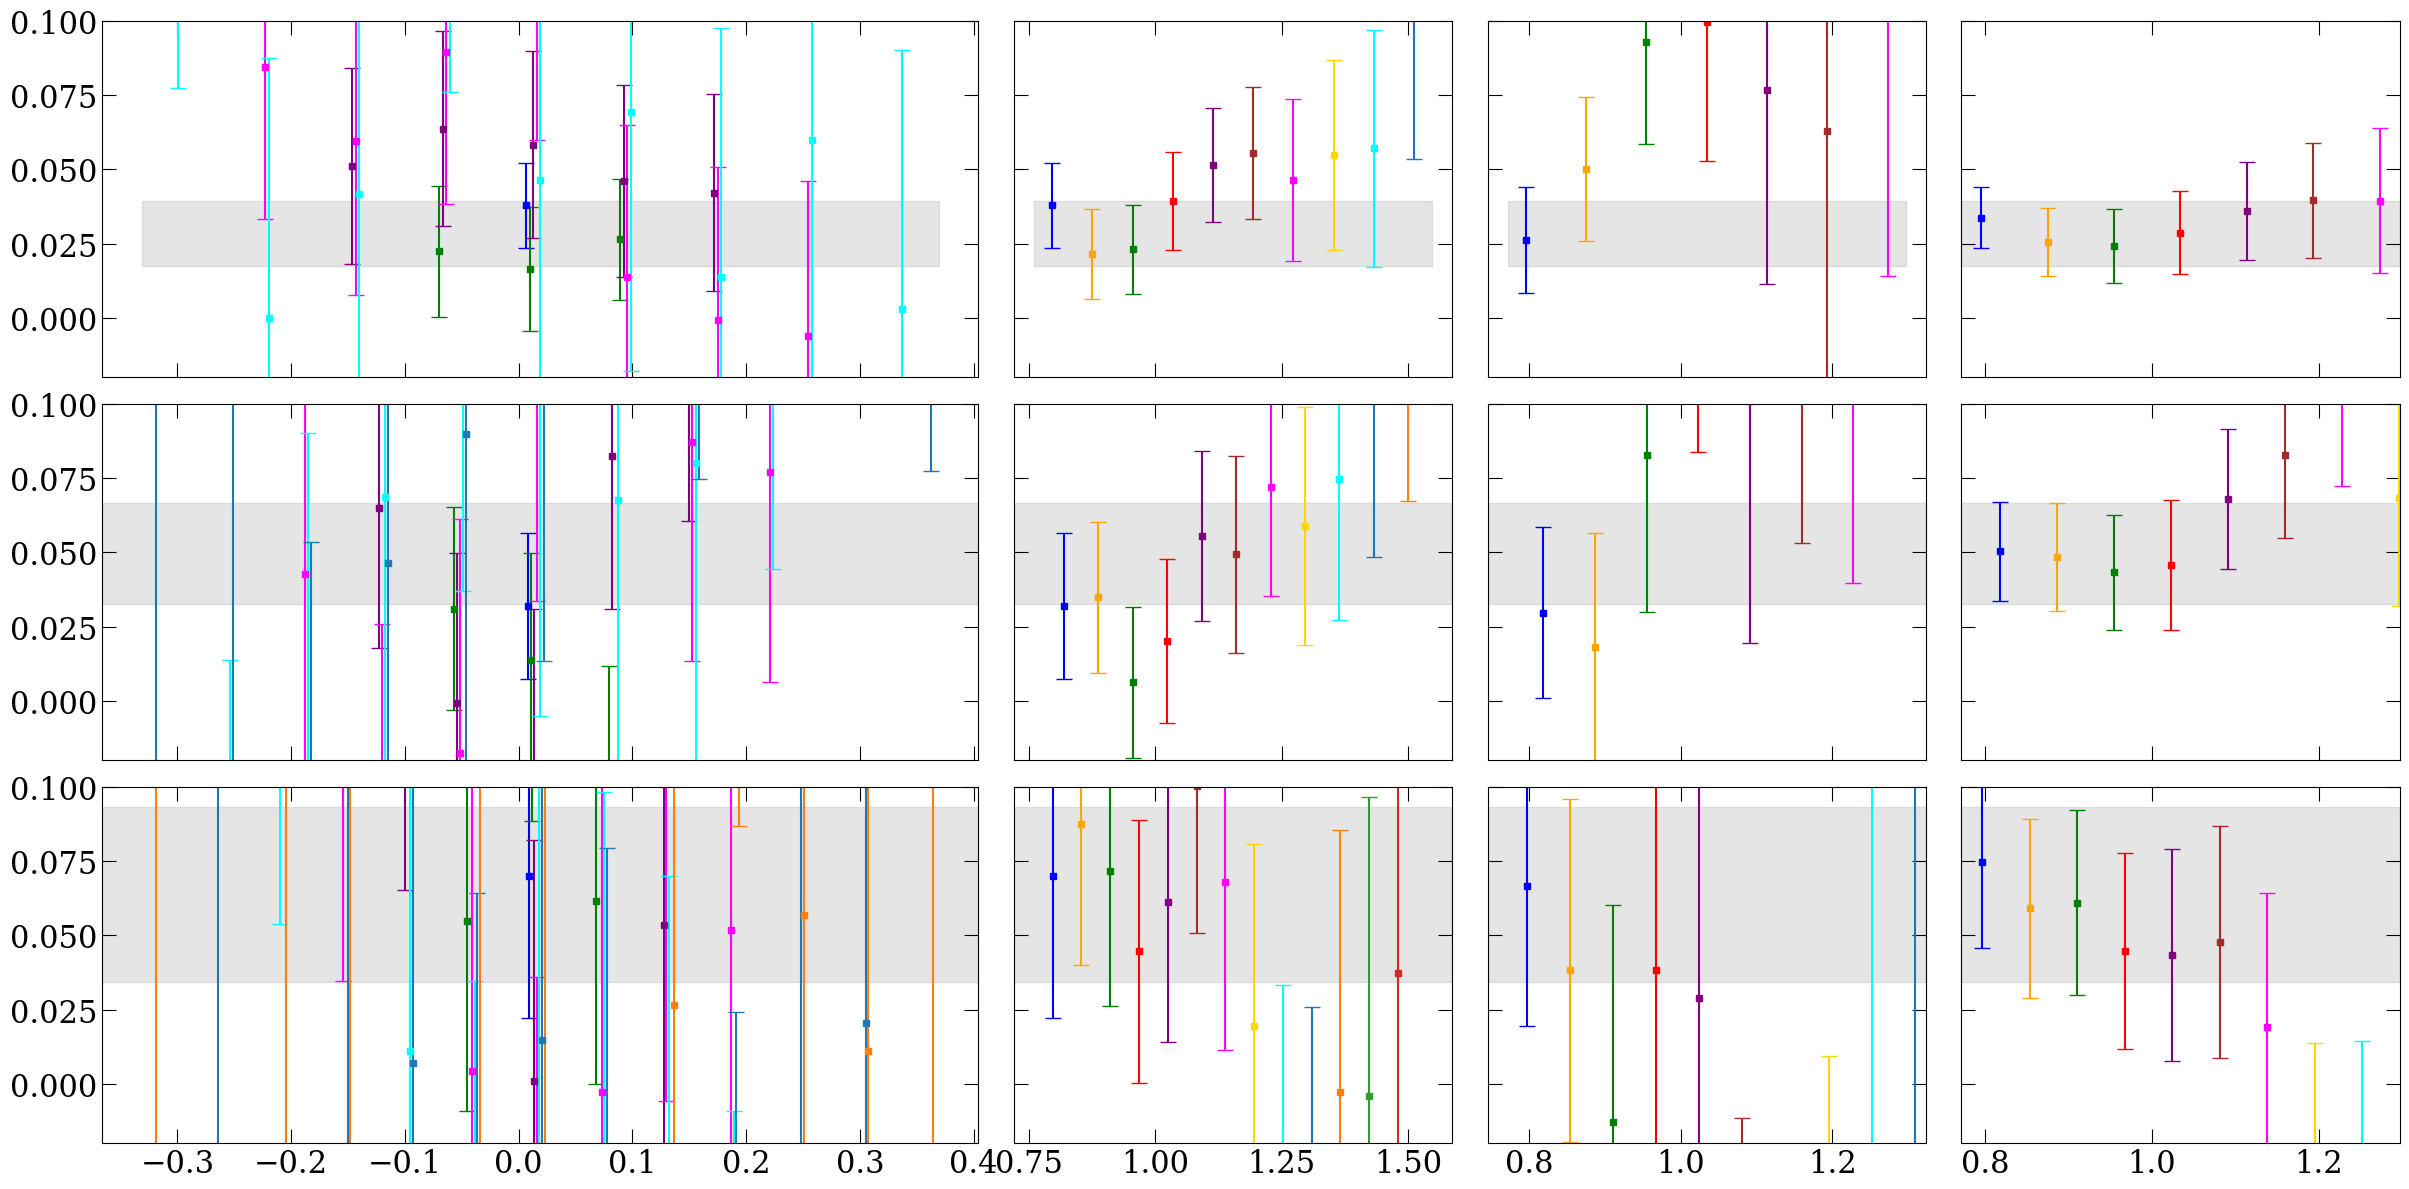

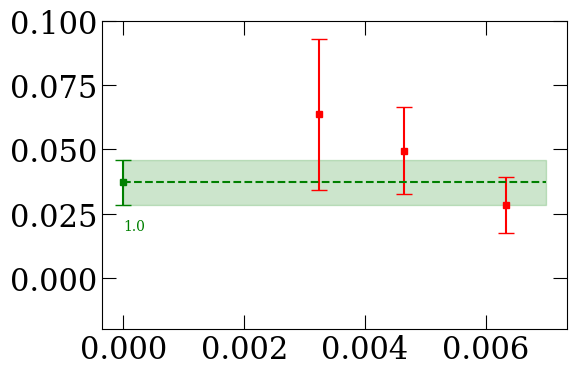

In [ ]:
enss_plt=['b','c','d']

ylim=[0,0.08]
ylim=[-0.02,0.1]

fix, axs = yu.getFigAxs(len(enss_plt),4,Lrow=4,Lcol=6,sharex='col',sharey=True, gridspec_kw={'width_ratios': [2, 1, 1, 1]})
axs[0,0].set_ylim(ylim)

symmetrizeQ=False

ens2Z=ens2Z_1d_V
j='js'

res={}
for i_ens,ens in enumerate(enss_plt):
    xunit=ens2a[ens]; yunit=ens2Z[ens]
    tfs=ens2tfs[ens]
    
    tc_cut=find_t_cloest(ens,0.4)
    tfmax_cut=find_t_cloest(ens,1.5)
    print(ens,tc_cut,tfmax_cut)
    
    tfs_fit=[tf for tf in tfs if tc_cut*2<=tf<=tfmax_cut]
    cN1=np.real(data[ens]['N1'])
    c3ptDic={tf:np.real(data[ens]['P4i'][j][tf]/(1j*2*np.pi/ens2N[ens])) for tf in tfs}
    if symmetrizeQ:
        c3ptDic={tf:(c3ptDic[tf]+c3ptDic[tf][:,::-1])/2 for tf in tfs}
    ratioDic={tf:c3ptDic[tf]/cN1[:,tf:tf+1] for tf in tfs}

    ax=axs[i_ens,0]
    colors=['b','orange','g','r','purple','brown','magenta','gold','cyan']
    t_cut=tc_cut
    for i_tf,tf in enumerate(tfs_fit):
        if tf%2!=0:
            continue
        ratio=ratioDic[tf]
        mean,err=yu.jackme(ratio)
        tcs=np.arange(t_cut,tf-t_cut+1)
        plt_x=(tcs-tf/2+0.02*(tf-6))*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
        # plt_x=(tcs-tf/2)*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
        ax.errorbar(plt_x,plt_y,plt_yerr,color=colors[i_tf] if i_tf<len(colors) else None)
        
    ax=axs[i_ens,1]
    tcmin=t_cut
    for i_tf,tf in enumerate(tfs_fit):
        # if tf<tcmin*2:
        #     continue
        ratio=ratioDic[tf]
        if tf>2*tcmin:
            y_jk=ratio[:,tcmin:tf-tcmin+1]
            if symmetrizeQ:
                y_jk=ratio[:,tcmin:tf//2+1]
            Ndata=y_jk.shape[1]
            def fitfunc(pars):
                return list(pars)*Ndata
            pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04])
        else:
            pars_jk=ratio[:,tf//2] if tf%2==0 else (ratio[:,tf//2]+ratio[:,tf//2+1])/2
            # print(tf,pars_jk.shape)
        
        mean,err=yu.jackme(pars_jk)
        plt_x=tf*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
        ax.errorbar(plt_x,plt_y,plt_yerr,color=colors[i_tf] if i_tf<len(colors) else None)  
        
    ax=axs[i_ens,2]
    tfmins=[tf for tf in tfs_fit[:-3] if tf>=2*tcmin]
    ratioSummedDic={tf:np.sum(ratioDic[tf][:,tcmin:tf-tcmin+1],axis=1) for tf in tfs}
    for tfmin in tfmins:
        y_jk=np.transpose([ratioSummedDic[tf] for tf in tfs_fit if tf>=tfmin])
        Ndata=y_jk.shape[1]
        def fitfunc(pars):
            g,c=pars
            return g*np.arange(Ndata)+c
        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04,1])
        
        mean,err=yu.jackme(pars_jk[:,0])
        plt_x=tfmin*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
        i_tf=tfs_fit.index(tfmin)
        ax.errorbar(plt_x,plt_y,plt_yerr,color=colors[i_tf] if i_tf<len(colors) else None)
        
    ax=axs[i_ens,3]
    tfmins=[tf for tf in tfs_fit[:-3] if tf>=2*tcmin]
    fits=[]
    for tfmin in tfmins:
        y_jk=np.concatenate([ratioDic[tf][:,tcmin:tf-tcmin+1] for tf in tfs_fit if tf>=tfmin],axis=1)
        if symmetrizeQ:
            y_jk=np.concatenate([ratioDic[tf][:,tcmin:tf//2+1] for tf in tfs_fit if tf>=tfmin],axis=1)

        Ndata=y_jk.shape[1]
        def fitfunc(pars):
            return list(pars)*Ndata
        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04])
        fits.append([tfmin,pars_jk,chi2_jk,Ndof])
        
        mean,err=yu.jackme(pars_jk[:,0])
        plt_x=tfmin*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
        i_tf=tfs_fit.index(tfmin)
        ax.errorbar(plt_x,plt_y,plt_yerr,color=colors[i_tf] if i_tf<len(colors) else None) 
    
    pars_jk,props_jk=yu.jackMA(fits)
    # ind_mpf=np.argmax(np.mean(props_jk,axis=0))
    pars_mean,pars_err=yu.jackme(pars_jk)
    res[ens]=[pars_mean[0],pars_err[0]]
    for icol in range(4):
        ax.set_xlim(ax.get_xlim())
        ax=axs[i_ens,icol]
        
        plt_x=ax.get_xlim(); plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
        ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='grey',alpha=0.2)    
        
        if icol==0:
            print(ens,yu.un2str(plt_y,plt_err))

plt.tight_layout()

fix, axs = yu.getFigAxs(1,1,Lrow=4,Lcol=6)
ax=axs[0,0]
ax.set_ylim(ylim)

a2s=np.array([ens2a[ens]**2 for ens in enss])
gs_m=np.array([res[ens][0]*ens2Z[ens] for ens in enss])
gs_e=np.array([res[ens][1]*ens2Z[ens] for ens in enss])

ax.errorbar(a2s,gs_m,gs_e,color='r') 

mean=gs_m; err=gs_e
def fitfunc(a2,g):
    return g+0*a2
popt,pcov=curve_fit(fitfunc,a2s,mean,sigma=err,absolute_sigma=True)
r=fitfunc(a2s,*popt)-mean
color='g'
chi2R=r.T @ np.linalg.inv(np.diag(err**2)) @ r / (len(enss)-1)
a2s2=np.arange(0,0.008,0.001)
res=fitfunc(a2s2,*popt)
ax.plot(a2s2,res,'--',color=color)
ax.fill_between(a2s2,res-[np.sqrt(pcov[0,0])]*len(a2s2),res+[np.sqrt(pcov[0,0])]*len(a2s2),color=color,alpha=0.2)
ax.errorbar([0],[popt[0]],np.sqrt(pcov[0,0]),color=color)
ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
ax.annotate("%0.1f" %chi2R,(0,popt[0]-np.sqrt(pcov[0,0])-chi2_shift),color=color)

print('c.l.',yu.un2str(popt[0],np.sqrt(pcov[0,0])))

# def fitfunc(a2,g,c):
#     return g+c*a2
# popt,pcov=curve_fit(fitfunc,a2s,mean,sigma=err,absolute_sigma=True)
# r=fitfunc(a2s,*popt)-mean
# color='b'
# chi2R=r.T @ np.linalg.inv(np.diag(err**2)) @ r / (len(enss)-1)
# a2s2=np.arange(0,0.008,0.001)
# res=fitfunc(a2s2,*popt)
# ax.plot(a2s2,res,'r-')

# ax.fill_between(a2s2,res-[np.sqrt(pcov[0,0])]*len(a2s2),res+[np.sqrt(pcov[0,0])]*len(a2s2),color='r',alpha=0.2)
# ax.errorbar([0],[popt[0]],np.sqrt(pcov[0,0]),color=color)
# ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
# ax.annotate("%0.1f" %chi2R,(0,popt[0]-np.sqrt(pcov[0,0])-chi2_shift),color=color)